## Classification based on pre model

In [79]:
import glob
import os
import numpy as np
import pandas as pd
import series_utils
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from hmmlearn import hmm
import hmm_helper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, make_scorer, roc_auc_score,roc_curve, auc
from sklearn.model_selection import cross_val_score
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
from statistics import stdev
from tqdm import tqdm
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from itertools import groupby
from statistics import mean
from statsmodels.stats.proportion import proportion_confint
import itertools

In [80]:
dirpath = '/home/jarvis/Documentos/catalina/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]

parcel="_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz"
np.random.seed(42)
random_state = 42

In [81]:
schafer_file = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_Centroid_RAS.csv'
schafer = pd.read_csv(schafer_file, header=None, skiprows=[0,1])
schafer['network'] = schafer[1].str.split('_').str.get(2)
schafer['network_id'] = schafer.network.astype("category").cat.codes
schafer_image = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_MNI152_2mm.nii'

In [82]:
def get_time_series_all(dirpath, subects, stimulus, scan, parcel):
    
    subject_list = []
    series_array = []
    
    for subject in subjects:
        file_path = f'{dirpath}/{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/roi_stats.csv'
        series = pd.read_csv(file_path, skiprows=[0,1], header=None, delimiter='\t')
        #scaled_series = series.apply(zscore)
        scaled_series = series.T
        scaled_series['network'] = schafer['network']
        scaled_series.drop(scaled_series.index[scaled_series['network'] == 'Limbic'], inplace=True)
        del scaled_series['network']
        series_array.append(scaled_series.values.T)
    return series_array

def get_all_data(scans, stimuli,subjects, dirpath, parcel): 
    
    scans_arrray = []
    
    for scan in scans:
        all_stimulus_array = []
        
        for stimulus in stimuli:
            stimulus_array = get_time_series_all(dirpath, subjects, stimulus, scan, parcel)
            all_stimulus_array.extend(stimulus_array)
    scans_arrray.extend(all_stimulus_array)
            
    return scans_arrray

In [83]:
def fraccional_occupacy(transitions,states):
    
    F = [0 for _ in range(states)]
    
    Len = len(transitions)
    
    for i in range(states):
        
        F[i] = (transitions.tolist().count(i)/Len)*100
    
    return F 

In [84]:
def mean_life_time(transitions,states):
    
    ML = [0 for _ in range(states)]
    
    for state in range(states):
        
        state_bool = [1 if i==state else 0 for i in transitions]
        
        size = len(state_bool)
        
        idx_list = [idx  for idx, val in enumerate(state_bool) if val == 0]
    
        
        split_list = [state_bool[i+1: j] for i, j in zip([-1] + idx_list, idx_list + [size])]
        size_list  = [len(b) for b in split_list if b != []]
        
        ML[state] = mean(size_list) if size_list else 0
        
        
    return ML

In [85]:
def interval_time(transitions,states):
    IT = [0 for _ in range(states)]
    
    for state in range(states):
        state_bool = [1 if i==state else 0 for i in transitions]
        
        intervals = [list(g) for k, g in groupby(state_bool, lambda x: x == 0) if k]
        
        if state_bool[0]==0 and intervals != []:
            intervals.pop(0)
        if state_bool[-1]==0 and intervals != []:
            intervals.pop(-1)
        lens = [len(a) for a in intervals]
        if len(lens)!=0:
            IT[state] = mean(lens)
    return IT

In [86]:
def number_visits(transitions,states):
    NV = [0 for _ in range(states)]
    
    for state in range(states):
        state_bool = [1 if i==state else 0 for i in transitions]
        
        size = len(state_bool)
        
        idx_list = [idx  for idx, val in enumerate(state_bool) if val == 0]
    
        
        split_list = [state_bool[i+1: j] for i, j in zip([-1] + idx_list, idx_list + [size])]
        visit_list = [b for b in split_list if b != []]
        
        
        NV[state] = len( visit_list)

    return NV

In [87]:
def average_zscore(array):
    all_subjects = []
    for subject_array in array:
        df_array = pd.DataFrame(subject_array.T)
        df_array['network'] = networks
        series_average = df_array.groupby('network').mean()
        scaler = StandardScaler()
        #scaled_series = scaler.fit_transform(series_average.T)
        #print(scaled_series)
        scaled_series = series_average.T.apply(zscore)
       
        all_subjects.append(scaled_series.values)
    return(np.array(all_subjects))

In [88]:
pre_occ = np.array(get_all_data(['_scan_restpre'], ['ses-occ'],subjects, dirpath, parcel))

pre_fro = np.array(get_all_data(['_scan_restpre'], ['ses-fro'],subjects, dirpath, parcel))
average_pre = (pre_occ  + pre_fro) / 2

all_networks = schafer['network']
all_networks.drop(all_networks.index[all_networks == 'Limbic'], inplace=True)
networks = all_networks.values
pre_sequences = average_zscore(average_pre)

In [89]:
pre_sequences.shape

(23, 600, 15)

In [90]:
post_occ = np.array(get_all_data(['_scan_restpost'], ['ses-occ'],subjects, dirpath, parcel))
post_fro = np.array(get_all_data(['_scan_restpost'], ['ses-fro'],subjects, dirpath, parcel))

post_occ_sequences = average_zscore(post_occ)

post_fro_sequences = average_zscore(post_fro)

lenght_post = np.array([600 for i in range(23)])
print('shape post occ', post_occ_sequences.shape)
print('shape fro occ', post_fro_sequences.shape)


shape post occ (23, 600, 15)
shape fro occ (23, 600, 15)


In [67]:
logo = LeaveOneGroupOut()
states = 28

In [28]:
all_series = np.concatenate((pre_sequences, post_occ_sequences, post_fro_sequences))
all_class = np.array(['pre']*23 +['occ']*23 + ['fro']*23)
y_all = np.array([0]*23 + [1]*46)
all_subjects = subjects *3
cat_subjects = pd.get_dummies(all_subjects)

subjects_id = cat_subjects.values.argmax(1)


In [281]:
state_folds = dict()
states = 16
Fold_dict = dict()
for fold, (train_index, test_index) in tqdm(enumerate(logo.split(all_series, all_class, subjects_id))):

    train = all_series[train_index]
    train_class = all_class[train_index]
    train_pre_index = np.where(train_class == "pre")
    train_occ_index = np.where(train_class == "occ")
    train_fro_index = np.where(train_class == "fro")
    
    test = all_series[test_index]
    test_class = all_class[test_index]
    
    test_pre_index = np.where(test_class == "pre")
    test_occ_index = np.where(test_class == "occ")
    test_fro_index = np.where(test_class == "fro")
    
    train_pre = train[train_pre_index]
    train_occ = train[train_occ_index]
    train_fro = train[train_fro_index]
    
    test_pre = test[test_pre_index]
    test_occ = test[test_occ_index]
    test_fro = test[test_fro_index]
    
    train_pre_concatenated = train_pre.reshape(-1, train_pre.shape[-1])
    len_train_pre = len(train_pre)
    lenghts_train_pre = np.array([600]*len_train_pre)
    
    train_post_occ_concatenated = train_occ.reshape(-1, train_occ.shape[-1])
    len_train_occ = len(train_occ)
    lenghts_train_occ = np.array([600]*len_train_occ)
    
    train_post_fro_concatenated = train_fro.reshape(-1, train_fro.shape[-1])
    len_train_fro = len(train_fro)
    lenghts_train_fro = np.array([600]*len_train_fro)
    
    test_pre_concatenated = test_pre.reshape(-1, test_pre.shape[-1])
    len_test_pre = len(test_pre)
    lenghts_test_pre = np.array([600]*len_test_pre)
    
    test_post_occ_concatenated = test_occ.reshape(-1, test_occ.shape[-1])
    len_test_occ = len(test_occ)
    lenghts_test_occ = np.array([600]*len_test_occ)
    
    test_post_fro_concatenated = test_fro.reshape(-1, test_fro.shape[-1])
    len_test_fro = len(test_fro)
    lenghts_test_fro = np.array([600]*len_test_fro)
    
    
    
    model_pre = hmm.GaussianHMM(n_components=states , covariance_type="full",n_iter=100, random_state=42)
    model_pre.fit(train_pre_concatenated, lenghts_train_pre.T)
    score = model_pre.score(train_pre_concatenated, lenghts_train_pre.T)
    
    predicted_sequences_pre =  model_pre.predict(train_pre_concatenated, lenghts_train_pre.T)
    splited_predicted_sequences_pre = np.array(np.split(np.array(predicted_sequences_pre), len_train_pre))
    predicted_sequences_occ = model_pre.predict(train_post_occ_concatenated, lenghts_train_occ.T)
    splited_predicted_sequences_occ = np.array(np.split(np.array(predicted_sequences_occ), len_train_occ))
    predicted_sequences_fro = model_pre.predict(train_post_fro_concatenated, lenghts_train_fro.T)
    splited_predicted_sequences_fro = np.array(np.split(np.array(predicted_sequences_fro), len_train_fro))
    
    
    predicted_sequences_pre_test =  model_pre.predict(test_pre_concatenated, lenghts_test_pre.T)
    splited_predicted_sequences_test_pre = np.array(np.split(np.array(predicted_sequences_pre_test), len_test_pre))
    predicted_sequences_occ_test = model_pre.predict(test_post_occ_concatenated, lenghts_test_occ.T)
    splited_predicted_sequences_test_occ = np.array(np.split(np.array(predicted_sequences_occ_test), len_test_occ))
    predicted_sequences_fro_test = model_pre.predict(test_post_fro_concatenated, lenghts_test_fro.T)
    splited_predicted_sequences_test_fro = np.array(np.split(np.array(predicted_sequences_fro_test), len_test_fro))
    

    
    Fold_dict[fold] ={'splited_predicted_sequences_pre': splited_predicted_sequences_pre, 'splited_predicted_sequences_occ': splited_predicted_sequences_occ, 'splited_predicted_sequences_fro': splited_predicted_sequences_fro,
                 'splited_predicted_sequences_test_pre': splited_predicted_sequences_test_pre, 'splited_predicted_sequences_test_occ': splited_predicted_sequences_test_occ, 'splited_predicted_sequences_test_fro': splited_predicted_sequences_test_fro,
                 'train_class': train_class, 'test_class': test_class, 'model': model_pre, 'model_score':score,
                  'subject_out': np.array(all_subjects)[test_index] }
        


23it [55:31, 144.84s/it]


In [216]:
with open('fold_dict_12_states.pkl', 'wb') as f:
    pickle.dump(Fold_dict, f)

In [215]:
Fold_dict

{0: {'splited_predicted_sequences_pre': array([[ 5,  5,  5, ...,  2,  2,  2],
         [11,  4,  4, ..., 10, 10, 10],
         [ 2,  2, 10, ...,  9,  9,  9],
         ...,
         [ 0,  0,  0, ...,  9,  9,  9],
         [11, 11, 11, ...,  5,  5,  5],
         [ 8,  8,  8, ...,  2,  2,  2]]),
  'splited_predicted_sequences_occ': array([[2, 2, 2, ..., 5, 5, 5],
         [0, 0, 0, ..., 7, 7, 7],
         [8, 8, 8, ..., 2, 2, 2],
         ...,
         [8, 8, 8, ..., 0, 0, 0],
         [5, 5, 5, ..., 1, 1, 1],
         [2, 2, 2, ..., 9, 9, 9]]),
  'splited_predicted_sequences_fro': array([[ 1,  1,  1, ...,  5,  5,  5],
         [ 8, 10, 10, ..., 10, 10, 10],
         [ 1,  1,  1, ...,  3,  3,  3],
         ...,
         [11, 11, 11, ..., 11,  8,  8],
         [11, 11, 11, ..., 10, 10, 10],
         [ 2,  2,  2, ..., 10, 10, 10]]),
  'splited_predicted_sequences_test_pre': array([[ 1,  1,  1,  1,  1,  3,  3,  3,  3,  3,  6,  6,  6,  6,  6,  6,
           7,  7,  7,  9,  9,  9,  9,  9,  9, 

In [217]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
df_validation_svm = pd.DataFrame()
states = 41

for c in Cs:
        
    predicts = []
    y_test = []
    predicts_train = []
    y_train = []
    scores_train = []
    scores_test = []
        
    for k,i in enumerate(Fold_dict):
        model = SVC(C=c, kernel='linear',random_state=random_state)
        fold =  Fold_dict[i]
        splited_predicted_sequences_pre = fold["splited_predicted_sequences_pre"]
        splited_predicted_sequences_occ = fold["splited_predicted_sequences_occ"]

        splited_predicted_sequences_test_pre = fold["splited_predicted_sequences_test_pre"]
        splited_predicted_sequences_test_occ = fold["splited_predicted_sequences_test_occ"]
    
        train_sequences = np.concatenate((splited_predicted_sequences_pre, splited_predicted_sequences_occ))  
        test_sequences = np.concatenate((splited_predicted_sequences_test_pre, splited_predicted_sequences_test_occ)) 
        
        fraccional_occupacy_train = []

        for predicted_sequence in train_sequences:
    
            F = fraccional_occupacy(predicted_sequence,states)
    
            fraccional_occupacy_train.append(F)

        fraccional_occupacy_train = np.array(fraccional_occupacy_train)
        
        
        fraccional_occupacy_test = []
        
        for predicted_sequence in test_sequences:
    
            F = fraccional_occupacy(predicted_sequence,states)
    
            fraccional_occupacy_test.append(F)

        fraccional_occupacy_test = np.array(fraccional_occupacy_test)
        
        mean_life_time_train = []

        for predicted_sequence in train_sequences:
    
            ML = mean_life_time(predicted_sequence,states)
    
            mean_life_time_train.append(ML)

        mean_life_time_train = np.array(mean_life_time_train)
        
        mean_life_time_test = []

        for predicted_sequence in test_sequences:
    
            ML = mean_life_time(predicted_sequence,states)
    
            mean_life_time_test.append(ML)

        mean_life_time_test = np.array(mean_life_time_test)
        
        interval_time_train = []
        
        for predicted_sequence in train_sequences:
    
            IT = interval_time(predicted_sequence,states)
    
            interval_time_train.append(IT)

        interval_time_train = np.array(interval_time_train)
        
        interval_time_test = []

        for predicted_sequence in test_sequences:
    
            IT = interval_time(predicted_sequence,states)
    
            interval_time_test.append(IT)

        interval_time_test = np.array(interval_time_test)

        
        X_train = np.concatenate(( fraccional_occupacy_train, mean_life_time_train, interval_time_train ), axis =1)
        X_train = fraccional_occupacy_train
        X_test = np.concatenate(( fraccional_occupacy_test, mean_life_time_test, interval_time_test ), axis = 1)
        X_test= fraccional_occupacy_test
        scaler = StandardScaler()
        X_train_scaled =  scaler.fit_transform(X_train)
        X_test_scaled =  scaler.transform(X_test)
        
        train_class = np.array([0]*len(splited_predicted_sequences_pre)+ [1]*len(splited_predicted_sequences_occ))
        test_class= np.array([0,1])
            
        model.fit(X_train_scaled, train_class)
        
        predict_train = model.predict(X_train_scaled)
        
        score_train = accuracy_score(train_class,  predict_train)
                
        scores_train.append(score_train)
        
        predict = model.predict(X_test_scaled)
        
        score_test = accuracy_score(test_class,  predict)
        
        scores_test.append(score_test)
            
        predicts.extend(list(predict))
        predicts_train.extend(list(predict_train))
    
        y_test.extend(list(test_class))
        y_train.extend(list(train_class))
            
      
        predicts = [int(a) for a in predicts]
        predict_train = [int(a) for a in predict_train]
    
    print(proportion_confint(np.sum(np.equal(predicts,y_test)),len(y_test),method='jeffreys'))
    print(accuracy_score(predicts,y_test))
    df_validation_svm = df_validation_svm.append({'C':c, 'mean_score_train':mean(scores_train), 'std_score_train': stdev(scores_train), 'mean_score_test':mean(scores_test), 'std_score_test':stdev(scores_test) }, ignore_index=True)


        
        

(0.44297305427668765, 0.7203748418685891)
0.5869565217391305
(0.42163871669468067, 0.7008717557517625)
0.5652173913043478
(0.40056983600031326, 0.6811036029978705)
0.5434782608695652
(0.40056983600031326, 0.6811036029978705)
0.5434782608695652
(0.42163871669468067, 0.7008717557517625)
0.5652173913043478
(0.40056983600031326, 0.6811036029978705)
0.5434782608695652
(0.42163871669468067, 0.7008717557517625)
0.5652173913043478


In [218]:
df_validation_svm

C  mean_score_test  mean_score_train  std_score_test  \
0     0.001         0.586957          0.660079        0.288104   
1     0.010         0.565217          0.663043        0.312772   
2     0.100         0.543478          0.754941        0.334156   
3     1.000         0.543478          0.777668        0.334156   
4    10.000         0.565217          0.802372        0.347208   
5   100.000         0.543478          0.808300        0.334156   
6  1000.000         0.565217          0.810277        0.347208   

   std_score_train  
0         0.046717  
1         0.052925  
2         0.062036  
3         0.058930  
4         0.066943  
5         0.072139  
6         0.065587

In [220]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
df_validation_svm = pd.DataFrame()
states = 41

for c in Cs:
        
    predicts = []
    y_test = []
    predicts_train = []
    y_train = []
    scores_train = []
    scores_test = []
        
    for k,i in enumerate(Fold_dict):
        model = SVC(C=c, kernel='linear',random_state=random_state)
        fold =  Fold_dict[i]
        splited_predicted_sequences_pre = fold["splited_predicted_sequences_pre"]
        splited_predicted_sequences_fro = fold["splited_predicted_sequences_fro"]

        splited_predicted_sequences_test_pre = fold["splited_predicted_sequences_test_pre"]
        splited_predicted_sequences_test_fro = fold["splited_predicted_sequences_test_fro"]
    
        train_sequences = np.concatenate((splited_predicted_sequences_pre, splited_predicted_sequences_fro))  
        test_sequences = np.concatenate((splited_predicted_sequences_test_pre, splited_predicted_sequences_test_fro)) 
        
        fraccional_occupacy_train = []

        for predicted_sequence in train_sequences:
    
            F = fraccional_occupacy(predicted_sequence,states)
    
            fraccional_occupacy_train.append(F)

        fraccional_occupacy_train = np.array(fraccional_occupacy_train)
        
        
        fraccional_occupacy_test = []
        
        for predicted_sequence in test_sequences:
    
            F = fraccional_occupacy(predicted_sequence,states)
    
            fraccional_occupacy_test.append(F)

        fraccional_occupacy_test = np.array(fraccional_occupacy_test)
        
        mean_life_time_train = []

        for predicted_sequence in train_sequences:
    
            ML = mean_life_time(predicted_sequence,states)
    
            mean_life_time_train.append(ML)

        mean_life_time_train = np.array(mean_life_time_train)
        
        mean_life_time_test = []

        for predicted_sequence in test_sequences:
    
            ML = mean_life_time(predicted_sequence,states)
    
            mean_life_time_test.append(ML)

        mean_life_time_test = np.array(mean_life_time_test)
        
        interval_time_train = []
        
        for predicted_sequence in train_sequences:
    
            IT = interval_time(predicted_sequence,states)
    
            interval_time_train.append(IT)

        interval_time_train = np.array(interval_time_train)
        
        interval_time_test = []

        for predicted_sequence in test_sequences:
    
            IT = interval_time(predicted_sequence,states)
    
            interval_time_test.append(IT)

        interval_time_test = np.array(interval_time_test)

        
        X_train = np.concatenate(( fraccional_occupacy_train, mean_life_time_train, interval_time_train ), axis =1)
        X_train = fraccional_occupacy_train
        X_test = np.concatenate(( fraccional_occupacy_test, mean_life_time_test, interval_time_test ), axis = 1)
        X_test= fraccional_occupacy_test
        scaler = StandardScaler()
        X_train_scaled =  scaler.fit_transform(X_train)
        X_test_scaled =  scaler.transform(X_test)
        
        train_class = np.array([0]*len(splited_predicted_sequences_pre)+ [1]*len(splited_predicted_sequences_fro))
        test_class= np.array([0,1])
            
        model.fit(X_train_scaled, train_class)
        
        predict_train = model.predict(X_train_scaled)
        
        score_train = accuracy_score(train_class,  predict_train)
                
        scores_train.append(score_train)
        
        predict = model.predict(X_test_scaled)
        
        score_test = accuracy_score(test_class,  predict)
        
        scores_test.append(score_test)
            
        predicts.extend(list(predict))
        predicts_train.extend(list(predict_train))
    
        y_test.extend(list(test_class))
        y_train.extend(list(train_class))
            
      
        predicts = [int(a) for a in predicts]
        predict_train = [int(a) for a in predict_train]
    
    print(proportion_confint(np.sum(np.equal(predicts,y_test)),len(y_test),method='jeffreys'))
    print(accuracy_score(predicts,y_test))
    df_validation_svm = df_validation_svm.append({'C':c, 'mean_score_train':mean(scores_train), 'std_score_train': stdev(scores_train), 'mean_score_test':mean(scores_test), 'std_score_test':stdev(scores_test) }, ignore_index=True)


        

(0.46457821668324994, 0.7396076472021729)
0.6086956521739131
(0.46457821668324994, 0.7396076472021729)
0.6086956521739131
(0.46457821668324994, 0.7396076472021729)
0.6086956521739131
(0.44297305427668765, 0.7203748418685891)
0.5869565217391305
(0.44297305427668765, 0.7203748418685891)
0.5869565217391305
(0.44297305427668765, 0.7203748418685891)
0.5869565217391305
(0.42163871669468067, 0.7008717557517625)
0.5652173913043478


In [221]:
df_validation_svm

C  mean_score_test  mean_score_train  std_score_test  \
0     0.001         0.608696          0.662055        0.299868   
1     0.010         0.608696          0.667984        0.299868   
2     0.100         0.608696          0.708498        0.299868   
3     1.000         0.586957          0.752964        0.288104   
4    10.000         0.586957          0.762846        0.325163   
5   100.000         0.586957          0.758893        0.325163   
6  1000.000         0.565217          0.758893        0.347208   

   std_score_train  
0         0.023040  
1         0.026308  
2         0.054240  
3         0.044040  
4         0.045879  
5         0.046344  
6         0.046344

In [91]:
def get_fractional_occupacy(splited_sequence,states):
    fraccional_occupacy_l = []

    for predicted_sequence in splited_sequence:
    
        F = fraccional_occupacy(predicted_sequence,states)
    
        fraccional_occupacy_l.append(F)

    return np.array(fraccional_occupacy_l)

def get_mean_life_time(splited_sequence,states):
    mean_life_time_l = []

    for predicted_sequence in splited_sequence:
    
        F = mean_life_time(predicted_sequence,states)
    
        mean_life_time_l.append(F)

    return np.array(mean_life_time_l)


def get_interval_time(splited_sequence,states):
    interval_time_l = []

    for predicted_sequence in splited_sequence:
    
        F = interval_time(predicted_sequence,states)
    
        interval_time_l.append(F)

    return np.array(interval_time_l)




In [92]:
with open('fold_dict_12_states.pkl', 'rb') as handle:
    Fold12 = pickle.load(handle)

In [93]:
Fold12

{0: {'splited_predicted_sequences_pre': array([[ 5,  5,  5, ...,  2,  2,  2],
         [11,  4,  4, ..., 10, 10, 10],
         [ 2,  2, 10, ...,  9,  9,  9],
         ...,
         [ 0,  0,  0, ...,  9,  9,  9],
         [11, 11, 11, ...,  5,  5,  5],
         [ 8,  8,  8, ...,  2,  2,  2]]),
  'splited_predicted_sequences_occ': array([[2, 2, 2, ..., 5, 5, 5],
         [0, 0, 0, ..., 7, 7, 7],
         [8, 8, 8, ..., 2, 2, 2],
         ...,
         [8, 8, 8, ..., 0, 0, 0],
         [5, 5, 5, ..., 1, 1, 1],
         [2, 2, 2, ..., 9, 9, 9]]),
  'splited_predicted_sequences_fro': array([[ 1,  1,  1, ...,  5,  5,  5],
         [ 8, 10, 10, ..., 10, 10, 10],
         [ 1,  1,  1, ...,  3,  3,  3],
         ...,
         [11, 11, 11, ..., 11,  8,  8],
         [11, 11, 11, ..., 10, 10, 10],
         [ 2,  2,  2, ..., 10, 10, 10]]),
  'splited_predicted_sequences_test_pre': array([[ 1,  1,  1,  1,  1,  3,  3,  3,  3,  3,  6,  6,  6,  6,  6,  6,
           7,  7,  7,  9,  9,  9,  9,  9,  9, 

## diff

In [76]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
df_validation_svm = pd.DataFrame()
states = 12

for c in Cs:
        
    predicts = []
    y_test = []
    predicts_train = []
    y_train = []
    scores_train = []
    scores_test = []
    y_proba = []
     
    for k,i in enumerate(Fold12):
        
        model = SVC(C=c, kernel='rbf',random_state=random_state,probability=True)
        
        fold =  Fold12[i]
        splited_predicted_sequences_pre = fold["splited_predicted_sequences_pre"]
        splited_predicted_sequences_occ = fold["splited_predicted_sequences_occ"]
        splited_predicted_sequences_fro = fold["splited_predicted_sequences_fro"]


        splited_predicted_sequences_test_pre = fold["splited_predicted_sequences_test_pre"]
        splited_predicted_sequences_test_occ = fold["splited_predicted_sequences_test_occ"]
        splited_predicted_sequences_test_fro = fold["splited_predicted_sequences_test_fro"]
    
        train_sequences = np.concatenate((splited_predicted_sequences_pre, splited_predicted_sequences_occ, splited_predicted_sequences_fro))  
        test_sequences = np.concatenate((splited_predicted_sequences_test_pre, splited_predicted_sequences_test_occ, splited_predicted_sequences_test_fro)) 
        
        fraccional_occupacy_train_pre = get_fractional_occupacy(splited_predicted_sequences_pre,states)
        fraccional_occupacy_train_occ = get_fractional_occupacy(splited_predicted_sequences_occ,states)
        fraccional_occupacy_train_fro = get_fractional_occupacy(splited_predicted_sequences_fro,states)
        fraccional_occupacy_test_pre = get_fractional_occupacy(splited_predicted_sequences_test_pre,states)
        fraccional_occupacy_test_occ = get_fractional_occupacy(splited_predicted_sequences_test_occ,states)
        fraccional_occupacy_test_fro = get_fractional_occupacy(splited_predicted_sequences_test_fro,states)
        
        fo_occ_diff = fraccional_occupacy_train_pre - fraccional_occupacy_train_occ
        fo_fro_diff = fraccional_occupacy_train_pre - fraccional_occupacy_train_fro
        
        fo_occ_diff_test = fraccional_occupacy_test_pre - fraccional_occupacy_test_occ
        fo_fro_diff_test = fraccional_occupacy_test_pre - fraccional_occupacy_test_fro
        
        mean_life_time_train_pre = get_mean_life_time(splited_predicted_sequences_pre,states)
        mean_life_time_train_occ = get_mean_life_time(splited_predicted_sequences_occ,states)
        mean_life_time_train_fro = get_mean_life_time(splited_predicted_sequences_fro,states)
        mean_life_time_test_pre = get_mean_life_time(splited_predicted_sequences_test_pre,states)
        mean_life_time_test_occ = get_mean_life_time(splited_predicted_sequences_test_occ,states)
        mean_life_time_test_fro = get_mean_life_time(splited_predicted_sequences_test_fro,states)
        
        mlt_occ_diff = mean_life_time_train_pre - mean_life_time_train_occ
        mlt_fro_diff = mean_life_time_train_pre - mean_life_time_train_fro
        
        mlt_occ_diff_test = mean_life_time_test_pre -mean_life_time_test_occ
        mlt_fro_diff_test = mean_life_time_test_pre - mean_life_time_test_fro
        
        interval_time_train_pre = get_interval_time(splited_predicted_sequences_pre,states)
        interval_time_train_occ = get_interval_time(splited_predicted_sequences_occ,states)
        interval_time_train_fro = get_interval_time(splited_predicted_sequences_fro,states)
        interval_time_test_pre = get_interval_time(splited_predicted_sequences_test_pre,states)
        interval_time_test_occ = get_interval_time(splited_predicted_sequences_test_occ,states)
        interval_time_test_fro = get_interval_time(splited_predicted_sequences_test_fro,states)
        
        print(interval_time_train_occ)
        print('interval time')
        print(interval_time_train_pre)
        print('interval time pre')
        print(interval_time_train_fro)
        
        it_occ_diff = interval_time_train_pre - interval_time_train_occ
        it_fro_diff = interval_time_train_pre - interval_time_train_fro
        
        it_occ_diff_test = interval_time_test_pre - interval_time_test_occ
        it_fro_diff_test = interval_time_test_pre - interval_time_test_fro
        
        print(it_occ_diff)
        print(it_fro_diff)
        
        all_variables_occ = np.concatenate((fo_occ_diff, mlt_occ_diff, it_occ_diff ), axis = 1)
        all_variables_fro = np.concatenate((fo_fro_diff, mlt_fro_diff, it_fro_diff ), axis = 1)
        
        all_variables_test_occ = np.concatenate((fo_occ_diff_test, mlt_occ_diff_test, it_occ_diff_test ), axis = 1)
        all_variables_test_fro = np.concatenate((fo_fro_diff_test, mlt_fro_diff_test, it_fro_diff_test ), axis = 1)
        
        #all_variables_occ = it_occ_diff
        #all_variables_fro = it_fro_diff 
        
        #all_variables_test_occ = it_occ_diff_test 
        #all_variables_test_fro = it_fro_diff_test
            
        X_train = np.concatenate((all_variables_occ,all_variables_occ ))
             
        X_test =  np.concatenate((all_variables_test_occ ,all_variables_test_fro ))
        
        scaler = StandardScaler()
        
        X_train_scaled =  scaler.fit_transform(X_train)
        X_test_scaled =  scaler.transform(X_test)
        
        train_class = np.array([0]*len(fo_occ_diff)+ [1]*len(fo_fro_diff))
        test_class= np.array([0]*len(fo_occ_diff_test)+ [1]*len(fo_fro_diff_test))
        
            
        model.fit(X_train_scaled, train_class)
        
        predict_train = model.predict(X_train_scaled)
        
        print(predict_train)
        
        score_train = accuracy_score(train_class,  predict_train)
        
        print(score_train)
                
        scores_train.append(score_train)
        
        predict = model.predict(X_test_scaled)
        
        score_test = accuracy_score(test_class,  predict)
        
        scores_test.append(score_test)
            
        predicts.extend(list(predict))
        
        predict_proba = model.predict_proba(X_test_scaled)[:,1]
        
        #predict_proba = model.fit(X_train_scaled, train_class).predict_proba(X_test_scaled)[:,1]
        #predict_proba = clf_prob.fit(X_train_scaled, train_class).predict_proba(X_test_scaled)
        
        predicts_train.extend(list(predict_train))
        
        y_proba.extend(list(predict_proba))
    
        y_test.extend(list(test_class))
        y_train.extend(list(train_class))
            
      
        predicts = [int(a) for a in predicts]
        predict_train = [int(a) for a in predict_train]
    print(proportion_confint(np.sum(np.equal(predicts,y_test)),len(y_test),method='jeffreys'))
    print(accuracy_score(predicts,y_test))
    print(confusion_matrix(y_test, predicts))
        
    df_validation_svm = df_validation_svm.append({'C':c, 'mean_score_train':mean(scores_train), 'std_score_train': stdev(scores_train), 'mean_score_test':mean(scores_test), 'std_score_test':stdev(scores_test), 'y':y_test, 'predict': predicts, 'y_proba': y_proba}, ignore_index=True)


        

[[ 92.         222.          19.13636364  59.14285714 308.
   44.90909091 146.          29.66666667  90.          37.2
   67.2         54.75      ]
 [ 54.         134.75        27.5         44.85714286  54.25
   43.6         49.          48.09090909  33.57142857 116.5
   44.27272727  65.        ]
 [ 50.4         45.          44.27272727  96.6         74.5
   76.28571429  84.25        75.66666667  36.           0.
   29.07142857  42.33333333]
 [  0.           0.          18.65217391 118.25       179.5
   23.57894737 113.          26.69230769  88.5         21.91666667
   80.66666667   0.        ]
 [ 67.5         27.41176471  63.25        56.83333333  50.625
   75.28571429  33.42857143 168.          46.66666667 108.
   51.          39.66666667]
 [ 66.85714286  98.75        44.09090909  85.25        75.33333333
   43.45454545  68.57142857  81.33333333  38.38461538 103.2
   58.22222222  65.4       ]
 [ 82.          23.05263158  42.8          0.          31.5
   81.33333333  28.33333333  98.

[[ 70.         195.          21.68421053   0.           0.
   70.4         32.          23.94117647  35.64285714  24.
   66.625       65.5       ]
 [ 58.25        46.81818182  33.90909091  78.33333333 108.
   46.5         37.28571429  51.          32.53333333 151.33333333
   60.42857143  49.2       ]
 [ 55.          68.71428571  40.07692308  35.42857143  29.92307692
   61.75        91.8        140.          82.83333333  78.16666667
   92.16666667  27.1875    ]
 [  0.          93.          13.85185185   0.           0.
  274.          29.41666667  18.58823529  90.           0.
   66.71428571  75.33333333]
 [ 23.7         42.125       71.75        34.          22.9047619
   69.          68.          89.5        116.          85.
   58.125       75.14285714]
 [ 49.          61.66666667  37.63636364  68.          70.
   74.          67.5         66.85714286  61.5         42.75
   42.63636364  47.27272727]
 [ 27.14285714  57.14285714  34.7         33.23076923  28.06666667
  153.         117

[[ 41.54545455  94.66666667  20.25       312.           0.
   65.          54.57142857  53.625       23.92857143 185.
   32.92857143   0.        ]
 [ 43.6         41.5         39.46153846  67.4        174.
   76.6         67.375       62.375       42.45454545  50.4
   58.25        58.        ]
 [ 52.11111111  60.125       44.1         33.          59.14285714
   39.83333333  42.77777778  75.66666667  64.125       48.27272727
   74.33333333  81.5       ]
 [ 41.07692308  73.4         24.63157895   0.          36.
   51.         143.5         43.36363636  18.29411765  61.66666667
   23.14285714  92.        ]
 [133.5         66.83333333 100.6         54.          62.625
   31.23076923  31.53333333  70.28571429 123.75        73.83333333
   76.14285714  26.05882353]
 [ 27.27777778  50.5        121.25        76.5         98.
   95.75        64.85714286  57.85714286 123.25        28.66666667
   58.375       68.        ]
 [ 34.53846154 110.          42.44444444  50.          42.14285714
   22.1

[[  0.          70.25        45.28571429  39.          71.75
   30.5         77.          26.875        0.           0.
   20.61111111  64.        ]
 [ 84.          63.125       74.66666667  58.42857143  58.
   59.          48.27272727  46.09090909  46.2         80.
   37.08333333  75.83333333]
 [ 38.5         29.91666667  83.          55.66666667  40.88888889
  105.          58.75        86.16666667  69.57142857  40.
   41.61538462 114.        ]
 [  0.          16.          56.375       59.85714286  91.2
   27.46153846  47.1         32.64285714 265.5          0.
   15.68         0.        ]
 [ 23.28571429  28.23529412 103.25        54.75        54.44444444
   81.16666667  61.33333333 181.33333333  46.55555556  36.91666667
   73.          35.15384615]
 [ 95.          64.85714286  42.14285714  46.33333333  86.4
   68.28571429  60.125      107.75        52.375      105.6
   21.21052632  97.4       ]
 [ 22.33333333  52.3        130.          40.22222222  38.11111111
    0.          52.888

[[  0.         481.          37.          46.125       48.
  311.          25.70588235  62.66666667  35.58333333  52.1
   29.91666667  37.75      ]
 [107.2         67.          71.66666667 130.25        70.6
   53.2         45.2         33.76923077  33.30769231  79.33333333
   46.2         47.44444444]
 [ 35.76923077  52.2         76.          33.54545455  87.
   53.5         13.         174.33333333  45.81818182  47.18181818
  155.66666667  40.27272727]
 [126.         127.66666667 151.         155.          50.
  112.5         22.4         77.          19.22727273  45.27272727
   22.53333333  47.63636364]
 [ 23.6         58.8         45.63636364  42.16666667  21.55555556
   52.         109.6         82.5        110.         130.
  125.          61.5       ]
 [ 47.33333333  95.2         83.          52.4         68.66666667
   73.28571429  64.71428571 103.2         39.72727273  37.91666667
   69.42857143  42.33333333]
 [ 19.78947368  74.          48.22222222  67.25        22.88235294
 

[[ 39.4         45.42857143   0.          58.33333333   0.
   90.          32.18181818  36.25        29.71428571  83.4
  101.          12.        ]
 [ 63.16666667  60.125       41.81818182  55.         103.
   36.78571429  49.88888889  52.8         37.83333333  62.125
   84.8         65.125     ]
 [ 69.4        175.66666667  34.69230769  32.16666667  48.77777778
   40.09090909  74.14285714  12.          53.9        109.8
   77.6         65.83333333]
 [174.          49.75       111.33333333 398.           0.
   47.2         23.9375      25.81818182  14.80769231  72.85714286
  227.          51.        ]
 [ 48.8         47.          54.625       22.7         27.6875
   76.16666667  95.         172.          99.33333333  52.11111111
   29.5625      37.7       ]
 [ 50.77777778  61.4         46.09090909  48.28571429  83.
   44.2         93.8         84.33333333  39.72727273  50.875
   70.14285714  74.42857143]
 [ 48.5          0.          52.5         78.85714286  24.5625
   57.         176.

[[ 77.8         47.75        34.6          0.           0.
   22.10526316  77.         192.          40.4        101.
    0.          32.78571429]
 [ 33.08333333  81.75       112.25        37.58333333 187.
   31.9375      58.44444444  61.125       36.55555556  87.25
   47.28571429  91.        ]
 [181.          50.          23.4          0.           0.
   15.875       49.9        194.          42.3        294.
   54.          33.07692308]
 [ 33.13333333  87.          80.83333333  21.47058824  53.44444444
   72.33333333  91.2         58.375       71.          69.16666667
   29.42857143 109.6       ]
 [ 38.81818182  66.         164.33333333  47.66666667 124.
   30.          75.28571429  45.8         39.38461538  64.5
   78.          66.85714286]
 [ 91.83333333 124.           0.          29.46666667  34.09090909
   38.          43.72727273  63.33333333  48.4         36.8
   23.0625       0.        ]
 [ 53.1         55.11111111  59.375       45.6         46.57142857
   44.16666667  33.8333

[[  0.          67.           0.          58.44444444  45.22222222
   34.16666667  26.76923077  26.375       26.625        0.
   62.71428571  37.5       ]
 [ 37.          46.66666667 122.          47.3         43.63636364
   42.16666667  56.5         81.6         34.91666667  89.16666667
   66.71428571  78.        ]
 [ 82.66666667 116.          52.42857143  91.33333333 154.33333333
   23.52941176  91.2         94.8         49.81818182  34.92307692
   48.71428571  60.5       ]
 [ 52.         357.           0.          50.33333333 111.5
   78.          26.78571429  20.4375      16.18518519   0.
   75.42857143  52.        ]
 [ 79.33333333  55.125      108.25        43.27272727  84.
   52.9         88.66666667 119.5         36.38461538  56.16666667
   56.11111111  48.33333333]
 [ 45.83333333  55.25        29.08333333  29.30769231  67.
   77.6          0.         103.          49.22222222  28.125
  124.5         37.83333333]
 [ 43.         141.          60.          31.83333333  45.3
   48.

[[ 55.88888889  65.14285714  51.1         44.9         82.6
   52.625       40.54545455  56.42857143  26.5        286.
   49.66666667  43.8       ]
 [ 53.          62.5         29.53333333 157.5          0.
   67.71428571  54.55555556  50.66666667  43.45454545  72.33333333
   63.375       47.66666667]
 [ 55.77777778  80.5         90.66666667  58.88888889  34.
   26.84615385  58.5          0.          12.75862069   0.
   26.58333333  44.        ]
 [ 65.83333333  72.16666667  52.125      103.25        53.85714286
  122.5         33.14285714  24.          98.          34.78571429
   74.14285714  35.33333333]
 [ 61.42857143  55.77777778  43.          75.8        134.
   97.6         33.76923077  48.          45.81818182  96.
   91.6         50.9       ]
 [ 53.25        33.28571429  83.66666667  90.33333333  52.14285714
   94.6         39.4         27.26666667  54.4         31.63636364
   80.75        44.        ]
 [ 66.875       36.75        78.71428571  29.18181818 119.66666667
   51.7777

[[  0.          13.          35.8         84.8         46.44444444
   51.1         31.46666667  29.          88.          22.10526316
  163.           0.        ]
 [156.          87.8         56.33333333  86.33333333  36.66666667
   30.66666667  43.          46.11111111  59.25        31.86666667
   80.5         84.33333333]
 [ 49.125       74.25        32.7         38.83333333  72.28571429
   91.16666667  40.75        65.          68.42857143  73.16666667
   51.75        60.14285714]
 [  0.         115.5         90.8         86.          36.23076923
   49.1         22.95        20.6875      77.5         28.6875
  192.          47.        ]
 [ 28.23529412  55.11111111  40.41666667  53.88888889  75.71428571
   64.33333333 123.75        99.4         32.5        211.
   52.1         33.        ]
 [ 59.16666667  41.66666667  35.08333333  52.5         66.57142857
   72.33333333  45.45454545  98.6         38.53846154  53.71428571
   89.16666667  69.        ]
 [ 40.66666667  39.          74.33

[[  0.          70.          51.2         22.47058824  61.85714286
   70.5         45.          19.33333333  40.           0.
   22.6          0.        ]
 [108.         126.5         49.3         28.66666667  40.72727273
   63.14285714  22.          74.28571429 113.25        40.81818182
   53.          57.5       ]
 [ 44.3         28.53333333  75.85714286  55.3         32.5
   55.5        122.          86.5         60.125       68.83333333
   75.33333333  48.5       ]
 [  0.         235.          45.27272727  16.30769231  71.57142857
  152.          56.25        27.75       167.           0.
   26.57142857   0.        ]
 [ 29.          28.27777778  49.5         94.66666667  41.625
   29.          80.33333333 182.33333333  58.14285714  50.11111111
  122.          45.27272727]
 [ 71.57142857  56.          49.5         31.2         59.75
   59.125       61.83333333  78.          59.83333333  59.625
   91.8         81.16666667]
 [ 36.66666667  53.3         68.5         56.375       61.666

[[ 44.54545455   0.         311.           0.          36.5
   29.91666667  17.69565217 208.          98.33333333  75.
   94.4         54.83333333]
 [ 36.8        119.          85.25       110.25        50.33333333
   56.88888889  20.47619048  34.71428571  58.11111111  87.33333333
   51.33333333  57.375     ]
 [ 56.55555556  31.91666667  93.33333333  48.75        63.375
   64.28571429  50.55555556  35.125       81.          60.25
   66.375      103.6       ]
 [ 22.31818182   0.         191.           0.          29.18181818
   27.875       27.16666667  69.28571429 250.          90.
   56.33333333  66.5       ]
 [ 79.66666667  57.11111111  41.72727273  24.11111111  88.66666667
   98.2         63.6         43.875       36.21428571  57.875
   48.6         77.28571429]
 [ 42.         106.25       106.4        113.          85.33333333
   95.          34.75        75.42857143  58.          36.41666667
   45.77777778  61.83333333]
 [ 26.4375      49.7         47.375       36.83333333  57.75


[[310.         328.          43.77777778  29.57142857  32.35714286
    0.          64.875       40.          64.         139.
    0.          26.85714286]
 [ 85.75        57.28571429  42.58333333  25.84615385  45.4
   62.875       40.1         50.5         73.          51.3
  182.          48.6       ]
 [ 97.5         68.71428571  64.          54.88888889  91.
   35.38461538  41.36363636  78.33333333 155.          61.875
   53.25        39.09090909]
 [  0.          93.5         34.91666667  15.65384615  27.70588235
  113.          34.5         26.30769231  79.83333333 142.
    0.         106.2       ]
 [ 99.4         54.25        56.57142857 128.         136.
   24.15789474  46.09090909  97.6         63.83333333  36.85714286
   27.58823529  45.8       ]
 [ 90.6         57.88888889  69.625       52.625      147.
   74.33333333  31.21428571  94.8         50.9         46.4
  116.5         56.5       ]
 [ 60.          36.           0.          33.625      145.
   25.6875      35.83333333  

[[ 29.73333333   0.          35.09090909  30.33333333  53.42857143
   57.71428571  77.           0.          54.77777778   0.
    0.          35.3       ]
 [ 42.75        66.71428571  53.5         55.          93.
   44.7         86.5         50.6         48.          84.66666667
  107.6         65.14285714]
 [ 40.33333333 105.25        59.44444444  74.71428571 100.2
  104.         225.5         51.77777778  32.8         33.
   44.55555556  67.42857143]
 [ 17.86956522 154.5         54.66666667  36.44444444 123.25
   29.18181818  39.          61.          30.3125       0.
    0.          32.        ]
 [ 85.66666667  47.36363636  51.85714286 102.66666667  66.2
   47.6         37.16666667  30.13333333  75.          23.65
   26.72222222  53.33333333]
 [ 41.41666667  39.33333333  89.5         32.8         65.25
   64.85714286 133.25        75.14285714  25.71428571  91.75
  105.5         82.66666667]
 [ 43.88888889  52.125      105.          72.          59.625
  106.75        54.57142857  2

[[  0.           0.          56.33333333  63.83333333  56.66666667
   27.83333333  35.92307692 137.          74.33333333  25.11764706
  310.         153.5       ]
 [101.8        115.5         79.          59.5         54.
   50.33333333  36.64285714  66.          55.          32.5
   46.7         85.75      ]
 [ 60.625       67.42857143  51.66666667  33.90909091  90.33333333
   64.125       72.85714286  88.8         60.42857143  31.4375
   44.          67.66666667]
 [  0.           0.          28.36363636   0.          42.11111111
   24.21428571  48.11111111   0.          54.25        15.44
  246.         223.        ]
 [ 26.41176471  40.36363636  88.83333333  32.73333333  56.4
   69.71428571  52.33333333  37.46153846  59.625       60.33333333
   42.22222222 103.        ]
 [ 92.2         50.44444444 103.          56.375       57.
   97.4         66.6         57.11111111  40.75        39.63636364
   45.8        105.8       ]
 [ 36.91666667  65.          54.25        48.54545455  44.375


[[ 25.41176471 111.66666667  32.          35.9         48.7
   62.          39.15384615  89.          35.5          0.
   81.2          0.        ]
 [ 31.0625      67.375       36.          74.57142857  42.55555556
  119.33333333  55.77777778  60.66666667  37.90909091  57.33333333
   65.33333333  39.54545455]
 [ 67.625       87.83333333  47.9        116.          48.88888889
   37.7        149.         233.5         40.61538462  42.375
   39.75        41.8       ]
 [ 56.5         76.2         49.33333333  36.8         29.93333333
    0.          43.          90.5         21.05263158   0.
   47.2         91.        ]
 [ 88.8         77.          43.125      166.33333333  87.5
   32.33333333  78.33333333  39.5         73.2         17.76
  112.5         29.73333333]
 [ 39.22222222  70.71428571  42.44444444 166.          43.33333333
   84.8         73.          87.          34.25        63.25
  118.          51.        ]
 [ 64.          60.66666667 119.          57.5         55.5
   39.909

[[  0.          35.27272727  50.25        35.3         28.46666667
  216.           0.           0.          44.90909091  78.
   33.36363636  78.        ]
 [ 79.33333333  60.625       50.2         46.33333333  34.33333333
   38.         100.         106.2         78.16666667  83.
   50.33333333  50.66666667]
 [ 50.33333333  31.13333333  74.14285714 162.          43.33333333
   61.          39.9         37.90909091 100.2          0.
  102.4         57.        ]
 [123.5         76.          44.          22.86666667  16.66666667
   46.5          0.           0.          46.72727273  74.
   27.          52.71428571]
 [ 40.46153846  58.11111111  80.42857143 165.66666667  96.66666667
   47.28571429  21.77777778  22.31578947  54.875      142.33333333
   88.33333333  67.42857143]
 [ 45.72727273  64.57142857  60.44444444  96.          54.
   58.          78.5         47.          58.625      155.
   79.          42.36363636]
 [ 37.54545455  61.14285714 157.5          0.          43.25
   46.666

[[ 57.6         50.44444444   0.          28.26666667  29.73333333
   52.42857143  37.53846154  67.75        74.75         0.
   65.28571429   0.        ]
 [ 88.83333333  73.57142857  84.16666667  59.88888889  49.6
   37.          27.06666667  91.8         49.2         66.42857143
   42.45454545  78.8       ]
 [ 46.125       58.625       45.55555556  44.1         76.57142857
  100.6         43.         119.         166.          44.27272727
   39.625       74.75      ]
 [ 35.69230769  65.85714286  32.42857143  98.8         79.
   55.75        91.8         38.69230769  81.25        50.
   65.375       49.7       ]
 [ 77.5         47.3         83.          61.125       80.
   62.          29.375       80.33333333  92.6         57.875
   34.53333333  77.2       ]
 [ 59.77777778  47.09090909  26.26666667 129.5        159.5
    0.          49.55555556  30.85714286  57.83333333  48.88888889
   27.92307692  37.81818182]
 [ 53.6         25.46153846  51.44444444  72.28571429  28.71428571
   37.

[[152.5         13.           0.          41.66666667  27.2
  306.           0.          24.92307692  42.2         97.33333333
   58.55555556 142.33333333]
 [132.          32.36363636 159.          64.42857143  36.64285714
   79.33333333  76.42857143  42.33333333  27.46666667  63.6
   41.3         43.25      ]
 [112.5         54.11111111  34.45454545  96.4         66.25
   93.4         49.44444444  90.6         51.5         44.54545455
   47.6         64.75      ]
 [186.          94.5          0.          43.25        27.375
    0.         212.          20.5625      16.7826087   61.44444444
  175.33333333  72.85714286]
 [ 62.33333333  29.8         36.46153846 135.75        73.
   43.16666667  35.92857143  81.33333333  97.2         75.4
   58.          62.        ]
 [134.75        50.6        161.          69.          48.54545455
   64.85714286  85.4         59.75        39.07692308  41.6
   39.27272727  45.72727273]
 [126.33333333  27.25        31.84615385  90.25        52.4
   32.4  

[[ 93.5        115.33333333  59.83333333   0.          32.
   23.47058824  87.          31.63636364   0.          52.66666667
   46.72727273  90.83333333]
 [ 59.14285714  32.6         46.625      108.          57.66666667
   33.46153846  46.55555556  37.41666667  89.          98.33333333
   31.8         40.08333333]
 [104.          36.63636364 119.75        44.33333333  72.85714286
   40.61538462  98.25        80.          87.2         44.2
   59.44444444  25.23529412]
 [119.66666667 195.          63.28571429   0.          23.38461538
   14.37037037 357.          29.           0.         234.
   40.66666667 160.66666667]
 [ 69.33333333  49.66666667  81.          24.73684211  58.44444444
   72.66666667  23.45       123.75        44.8         47.6
   42.63636364  69.125     ]
 [ 52.22222222  51.2         69.625       81.25       119.5
   39.36363636  95.8         68.42857143  71.33333333  59.875
   33.71428571  46.5       ]
 [ 33.5         28.2        145.5         34.07692308  82.666666

[[113.5         30.          25.625       37.61538462   0.
   27.625       49.           0.          59.33333333 193.
    0.          64.875     ]
 [ 67.66666667  56.          33.85714286  35.4         80.25
   37.76923077  39.5         78.6        127.75        85.5
   57.875       63.5       ]
 [148.5         45.54545455  27.11764706  31.8125       0.
   22.5         23.90909091  51.           0.           0.
  178.          31.71428571]
 [ 52.88888889  68.4         71.28571429  97.6         23.77777778
   97.8        106.          25.75        29.23529412 173.66666667
   76.5         49.88888889]
 [ 53.88888889  58.42857143  42.5         20.75        91.6
   79.33333333  94.6         63.66666667  54.4         68.5
   57.5         44.81818182]
 [ 54.         124.66666667  41.55555556  50.22222222  20.68421053
    0.          37.83333333  24.93333333  65.75        42.88888889
  108.25        46.88888889]
 [ 44.11111111  45.          53.33333333  57.88888889  40.72727273
   62.5       

[[ 34.85714286  48.5          0.          31.18181818   0.
    0.          23.66666667  99.33333333  89.75       126.33333333
   55.22222222   0.        ]
 [ 39.23076923  41.63636364  57.28571429  50.4         72.16666667
  184.5         47.63636364  67.          57.25        36.21428571
   36.25        75.14285714]
 [ 33.25        33.71428571  68.         116.         120.
   44.9         94.         110.5        286.          36.75
   71.57142857  29.61538462]
 [ 33.54545455  25.66666667  42.          23.           0.
    0.          17.86666667 225.          86.33333333 108.66666667
   34.85714286   0.        ]
 [ 73.33333333  36.          37.58333333  99.          66.125
   22.64705882 107.2         46.          75.71428571  46.4
   88.6         30.375     ]
 [ 59.125       20.89473684  62.16666667  99.          84.83333333
   95.          95.8         73.71428571  42.85714286  36.
   75.14285714  74.75      ]
 [ 44.625       84.          24.5625       0.          51.
   33.75     

[[ 66.25        78.6          0.          28.5         53.5
  137.         120.66666667   0.           0.          29.25
   34.85714286  22.52631579]
 [ 50.2        130.25        77.5         47.44444444  44.63636364
  114.          59.14285714  41.09090909  76.14285714  45.90909091
   27.64705882  83.66666667]
 [ 91.4         24.25        66.66666667  48.27272727  89.
  129.5          0.          40.83333333  40.1        114.75
   33.46153846  62.14285714]
 [ 68.71428571 370.           0.          24.76470588  65.14285714
  126.          87.2        193.           0.          20.11111111
   39.25        21.07692308]
 [ 45.4         35.5         48.22222222  79.75        80.6
   47.18181818  52.5         44.85714286  29.5         69.57142857
   49.5        182.33333333]
 [ 34.53846154  92.83333333  26.26666667  61.           0.
   44.6         52.44444444  48.5         24.72222222   0.
   38.81818182 186.        ]
 [ 34.2         44.58333333  83.2         52.33333333  33.35714286
   60

[[ 92.         222.          19.13636364  59.14285714 308.
   44.90909091 146.          29.66666667  90.          37.2
   67.2         54.75      ]
 [ 54.         134.75        27.5         44.85714286  54.25
   43.6         49.          48.09090909  33.57142857 116.5
   44.27272727  65.        ]
 [ 50.4         45.          44.27272727  96.6         74.5
   76.28571429  84.25        75.66666667  36.           0.
   29.07142857  42.33333333]
 [  0.           0.          18.65217391 118.25       179.5
   23.57894737 113.          26.69230769  88.5         21.91666667
   80.66666667   0.        ]
 [ 67.5         27.41176471  63.25        56.83333333  50.625
   75.28571429  33.42857143 168.          46.66666667 108.
   51.          39.66666667]
 [ 66.85714286  98.75        44.09090909  85.25        75.33333333
   43.45454545  68.57142857  81.33333333  38.38461538 103.2
   58.22222222  65.4       ]
 [ 82.          23.05263158  42.8          0.          31.5
   81.33333333  28.33333333  98.

[[ 70.         195.          21.68421053   0.           0.
   70.4         32.          23.94117647  35.64285714  24.
   66.625       65.5       ]
 [ 58.25        46.81818182  33.90909091  78.33333333 108.
   46.5         37.28571429  51.          32.53333333 151.33333333
   60.42857143  49.2       ]
 [ 55.          68.71428571  40.07692308  35.42857143  29.92307692
   61.75        91.8        140.          82.83333333  78.16666667
   92.16666667  27.1875    ]
 [  0.          93.          13.85185185   0.           0.
  274.          29.41666667  18.58823529  90.           0.
   66.71428571  75.33333333]
 [ 23.7         42.125       71.75        34.          22.9047619
   69.          68.          89.5        116.          85.
   58.125       75.14285714]
 [ 49.          61.66666667  37.63636364  68.          70.
   74.          67.5         66.85714286  61.5         42.75
   42.63636364  47.27272727]
 [ 27.14285714  57.14285714  34.7         33.23076923  28.06666667
  153.         117

[[ 41.54545455  94.66666667  20.25       312.           0.
   65.          54.57142857  53.625       23.92857143 185.
   32.92857143   0.        ]
 [ 43.6         41.5         39.46153846  67.4        174.
   76.6         67.375       62.375       42.45454545  50.4
   58.25        58.        ]
 [ 52.11111111  60.125       44.1         33.          59.14285714
   39.83333333  42.77777778  75.66666667  64.125       48.27272727
   74.33333333  81.5       ]
 [ 41.07692308  73.4         24.63157895   0.          36.
   51.         143.5         43.36363636  18.29411765  61.66666667
   23.14285714  92.        ]
 [133.5         66.83333333 100.6         54.          62.625
   31.23076923  31.53333333  70.28571429 123.75        73.83333333
   76.14285714  26.05882353]
 [ 27.27777778  50.5        121.25        76.5         98.
   95.75        64.85714286  57.85714286 123.25        28.66666667
   58.375       68.        ]
 [ 34.53846154 110.          42.44444444  50.          42.14285714
   22.1

[[  0.          70.25        45.28571429  39.          71.75
   30.5         77.          26.875        0.           0.
   20.61111111  64.        ]
 [ 84.          63.125       74.66666667  58.42857143  58.
   59.          48.27272727  46.09090909  46.2         80.
   37.08333333  75.83333333]
 [ 38.5         29.91666667  83.          55.66666667  40.88888889
  105.          58.75        86.16666667  69.57142857  40.
   41.61538462 114.        ]
 [  0.          16.          56.375       59.85714286  91.2
   27.46153846  47.1         32.64285714 265.5          0.
   15.68         0.        ]
 [ 23.28571429  28.23529412 103.25        54.75        54.44444444
   81.16666667  61.33333333 181.33333333  46.55555556  36.91666667
   73.          35.15384615]
 [ 95.          64.85714286  42.14285714  46.33333333  86.4
   68.28571429  60.125      107.75        52.375      105.6
   21.21052632  97.4       ]
 [ 22.33333333  52.3        130.          40.22222222  38.11111111
    0.          52.888

[[  0.         481.          37.          46.125       48.
  311.          25.70588235  62.66666667  35.58333333  52.1
   29.91666667  37.75      ]
 [107.2         67.          71.66666667 130.25        70.6
   53.2         45.2         33.76923077  33.30769231  79.33333333
   46.2         47.44444444]
 [ 35.76923077  52.2         76.          33.54545455  87.
   53.5         13.         174.33333333  45.81818182  47.18181818
  155.66666667  40.27272727]
 [126.         127.66666667 151.         155.          50.
  112.5         22.4         77.          19.22727273  45.27272727
   22.53333333  47.63636364]
 [ 23.6         58.8         45.63636364  42.16666667  21.55555556
   52.         109.6         82.5        110.         130.
  125.          61.5       ]
 [ 47.33333333  95.2         83.          52.4         68.66666667
   73.28571429  64.71428571 103.2         39.72727273  37.91666667
   69.42857143  42.33333333]
 [ 19.78947368  74.          48.22222222  67.25        22.88235294
 

[[ 39.4         45.42857143   0.          58.33333333   0.
   90.          32.18181818  36.25        29.71428571  83.4
  101.          12.        ]
 [ 63.16666667  60.125       41.81818182  55.         103.
   36.78571429  49.88888889  52.8         37.83333333  62.125
   84.8         65.125     ]
 [ 69.4        175.66666667  34.69230769  32.16666667  48.77777778
   40.09090909  74.14285714  12.          53.9        109.8
   77.6         65.83333333]
 [174.          49.75       111.33333333 398.           0.
   47.2         23.9375      25.81818182  14.80769231  72.85714286
  227.          51.        ]
 [ 48.8         47.          54.625       22.7         27.6875
   76.16666667  95.         172.          99.33333333  52.11111111
   29.5625      37.7       ]
 [ 50.77777778  61.4         46.09090909  48.28571429  83.
   44.2         93.8         84.33333333  39.72727273  50.875
   70.14285714  74.42857143]
 [ 48.5          0.          52.5         78.85714286  24.5625
   57.         176.

[[ 77.8         47.75        34.6          0.           0.
   22.10526316  77.         192.          40.4        101.
    0.          32.78571429]
 [ 33.08333333  81.75       112.25        37.58333333 187.
   31.9375      58.44444444  61.125       36.55555556  87.25
   47.28571429  91.        ]
 [181.          50.          23.4          0.           0.
   15.875       49.9        194.          42.3        294.
   54.          33.07692308]
 [ 33.13333333  87.          80.83333333  21.47058824  53.44444444
   72.33333333  91.2         58.375       71.          69.16666667
   29.42857143 109.6       ]
 [ 38.81818182  66.         164.33333333  47.66666667 124.
   30.          75.28571429  45.8         39.38461538  64.5
   78.          66.85714286]
 [ 91.83333333 124.           0.          29.46666667  34.09090909
   38.          43.72727273  63.33333333  48.4         36.8
   23.0625       0.        ]
 [ 53.1         55.11111111  59.375       45.6         46.57142857
   44.16666667  33.8333

[[  0.          67.           0.          58.44444444  45.22222222
   34.16666667  26.76923077  26.375       26.625        0.
   62.71428571  37.5       ]
 [ 37.          46.66666667 122.          47.3         43.63636364
   42.16666667  56.5         81.6         34.91666667  89.16666667
   66.71428571  78.        ]
 [ 82.66666667 116.          52.42857143  91.33333333 154.33333333
   23.52941176  91.2         94.8         49.81818182  34.92307692
   48.71428571  60.5       ]
 [ 52.         357.           0.          50.33333333 111.5
   78.          26.78571429  20.4375      16.18518519   0.
   75.42857143  52.        ]
 [ 79.33333333  55.125      108.25        43.27272727  84.
   52.9         88.66666667 119.5         36.38461538  56.16666667
   56.11111111  48.33333333]
 [ 45.83333333  55.25        29.08333333  29.30769231  67.
   77.6          0.         103.          49.22222222  28.125
  124.5         37.83333333]
 [ 43.         141.          60.          31.83333333  45.3
   48.

[[ 55.88888889  65.14285714  51.1         44.9         82.6
   52.625       40.54545455  56.42857143  26.5        286.
   49.66666667  43.8       ]
 [ 53.          62.5         29.53333333 157.5          0.
   67.71428571  54.55555556  50.66666667  43.45454545  72.33333333
   63.375       47.66666667]
 [ 55.77777778  80.5         90.66666667  58.88888889  34.
   26.84615385  58.5          0.          12.75862069   0.
   26.58333333  44.        ]
 [ 65.83333333  72.16666667  52.125      103.25        53.85714286
  122.5         33.14285714  24.          98.          34.78571429
   74.14285714  35.33333333]
 [ 61.42857143  55.77777778  43.          75.8        134.
   97.6         33.76923077  48.          45.81818182  96.
   91.6         50.9       ]
 [ 53.25        33.28571429  83.66666667  90.33333333  52.14285714
   94.6         39.4         27.26666667  54.4         31.63636364
   80.75        44.        ]
 [ 66.875       36.75        78.71428571  29.18181818 119.66666667
   51.7777

[[  0.          13.          35.8         84.8         46.44444444
   51.1         31.46666667  29.          88.          22.10526316
  163.           0.        ]
 [156.          87.8         56.33333333  86.33333333  36.66666667
   30.66666667  43.          46.11111111  59.25        31.86666667
   80.5         84.33333333]
 [ 49.125       74.25        32.7         38.83333333  72.28571429
   91.16666667  40.75        65.          68.42857143  73.16666667
   51.75        60.14285714]
 [  0.         115.5         90.8         86.          36.23076923
   49.1         22.95        20.6875      77.5         28.6875
  192.          47.        ]
 [ 28.23529412  55.11111111  40.41666667  53.88888889  75.71428571
   64.33333333 123.75        99.4         32.5        211.
   52.1         33.        ]
 [ 59.16666667  41.66666667  35.08333333  52.5         66.57142857
   72.33333333  45.45454545  98.6         38.53846154  53.71428571
   89.16666667  69.        ]
 [ 40.66666667  39.          74.33

[[  0.          70.          51.2         22.47058824  61.85714286
   70.5         45.          19.33333333  40.           0.
   22.6          0.        ]
 [108.         126.5         49.3         28.66666667  40.72727273
   63.14285714  22.          74.28571429 113.25        40.81818182
   53.          57.5       ]
 [ 44.3         28.53333333  75.85714286  55.3         32.5
   55.5        122.          86.5         60.125       68.83333333
   75.33333333  48.5       ]
 [  0.         235.          45.27272727  16.30769231  71.57142857
  152.          56.25        27.75       167.           0.
   26.57142857   0.        ]
 [ 29.          28.27777778  49.5         94.66666667  41.625
   29.          80.33333333 182.33333333  58.14285714  50.11111111
  122.          45.27272727]
 [ 71.57142857  56.          49.5         31.2         59.75
   59.125       61.83333333  78.          59.83333333  59.625
   91.8         81.16666667]
 [ 36.66666667  53.3         68.5         56.375       61.666

[[ 44.54545455   0.         311.           0.          36.5
   29.91666667  17.69565217 208.          98.33333333  75.
   94.4         54.83333333]
 [ 36.8        119.          85.25       110.25        50.33333333
   56.88888889  20.47619048  34.71428571  58.11111111  87.33333333
   51.33333333  57.375     ]
 [ 56.55555556  31.91666667  93.33333333  48.75        63.375
   64.28571429  50.55555556  35.125       81.          60.25
   66.375      103.6       ]
 [ 22.31818182   0.         191.           0.          29.18181818
   27.875       27.16666667  69.28571429 250.          90.
   56.33333333  66.5       ]
 [ 79.66666667  57.11111111  41.72727273  24.11111111  88.66666667
   98.2         63.6         43.875       36.21428571  57.875
   48.6         77.28571429]
 [ 42.         106.25       106.4        113.          85.33333333
   95.          34.75        75.42857143  58.          36.41666667
   45.77777778  61.83333333]
 [ 26.4375      49.7         47.375       36.83333333  57.75


[[310.         328.          43.77777778  29.57142857  32.35714286
    0.          64.875       40.          64.         139.
    0.          26.85714286]
 [ 85.75        57.28571429  42.58333333  25.84615385  45.4
   62.875       40.1         50.5         73.          51.3
  182.          48.6       ]
 [ 97.5         68.71428571  64.          54.88888889  91.
   35.38461538  41.36363636  78.33333333 155.          61.875
   53.25        39.09090909]
 [  0.          93.5         34.91666667  15.65384615  27.70588235
  113.          34.5         26.30769231  79.83333333 142.
    0.         106.2       ]
 [ 99.4         54.25        56.57142857 128.         136.
   24.15789474  46.09090909  97.6         63.83333333  36.85714286
   27.58823529  45.8       ]
 [ 90.6         57.88888889  69.625       52.625      147.
   74.33333333  31.21428571  94.8         50.9         46.4
  116.5         56.5       ]
 [ 60.          36.           0.          33.625      145.
   25.6875      35.83333333  

[[ 29.73333333   0.          35.09090909  30.33333333  53.42857143
   57.71428571  77.           0.          54.77777778   0.
    0.          35.3       ]
 [ 42.75        66.71428571  53.5         55.          93.
   44.7         86.5         50.6         48.          84.66666667
  107.6         65.14285714]
 [ 40.33333333 105.25        59.44444444  74.71428571 100.2
  104.         225.5         51.77777778  32.8         33.
   44.55555556  67.42857143]
 [ 17.86956522 154.5         54.66666667  36.44444444 123.25
   29.18181818  39.          61.          30.3125       0.
    0.          32.        ]
 [ 85.66666667  47.36363636  51.85714286 102.66666667  66.2
   47.6         37.16666667  30.13333333  75.          23.65
   26.72222222  53.33333333]
 [ 41.41666667  39.33333333  89.5         32.8         65.25
   64.85714286 133.25        75.14285714  25.71428571  91.75
  105.5         82.66666667]
 [ 43.88888889  52.125      105.          72.          59.625
  106.75        54.57142857  2

[[  0.           0.          56.33333333  63.83333333  56.66666667
   27.83333333  35.92307692 137.          74.33333333  25.11764706
  310.         153.5       ]
 [101.8        115.5         79.          59.5         54.
   50.33333333  36.64285714  66.          55.          32.5
   46.7         85.75      ]
 [ 60.625       67.42857143  51.66666667  33.90909091  90.33333333
   64.125       72.85714286  88.8         60.42857143  31.4375
   44.          67.66666667]
 [  0.           0.          28.36363636   0.          42.11111111
   24.21428571  48.11111111   0.          54.25        15.44
  246.         223.        ]
 [ 26.41176471  40.36363636  88.83333333  32.73333333  56.4
   69.71428571  52.33333333  37.46153846  59.625       60.33333333
   42.22222222 103.        ]
 [ 92.2         50.44444444 103.          56.375       57.
   97.4         66.6         57.11111111  40.75        39.63636364
   45.8        105.8       ]
 [ 36.91666667  65.          54.25        48.54545455  44.375


[[ 25.41176471 111.66666667  32.          35.9         48.7
   62.          39.15384615  89.          35.5          0.
   81.2          0.        ]
 [ 31.0625      67.375       36.          74.57142857  42.55555556
  119.33333333  55.77777778  60.66666667  37.90909091  57.33333333
   65.33333333  39.54545455]
 [ 67.625       87.83333333  47.9        116.          48.88888889
   37.7        149.         233.5         40.61538462  42.375
   39.75        41.8       ]
 [ 56.5         76.2         49.33333333  36.8         29.93333333
    0.          43.          90.5         21.05263158   0.
   47.2         91.        ]
 [ 88.8         77.          43.125      166.33333333  87.5
   32.33333333  78.33333333  39.5         73.2         17.76
  112.5         29.73333333]
 [ 39.22222222  70.71428571  42.44444444 166.          43.33333333
   84.8         73.          87.          34.25        63.25
  118.          51.        ]
 [ 64.          60.66666667 119.          57.5         55.5
   39.909

[[  0.          35.27272727  50.25        35.3         28.46666667
  216.           0.           0.          44.90909091  78.
   33.36363636  78.        ]
 [ 79.33333333  60.625       50.2         46.33333333  34.33333333
   38.         100.         106.2         78.16666667  83.
   50.33333333  50.66666667]
 [ 50.33333333  31.13333333  74.14285714 162.          43.33333333
   61.          39.9         37.90909091 100.2          0.
  102.4         57.        ]
 [123.5         76.          44.          22.86666667  16.66666667
   46.5          0.           0.          46.72727273  74.
   27.          52.71428571]
 [ 40.46153846  58.11111111  80.42857143 165.66666667  96.66666667
   47.28571429  21.77777778  22.31578947  54.875      142.33333333
   88.33333333  67.42857143]
 [ 45.72727273  64.57142857  60.44444444  96.          54.
   58.          78.5         47.          58.625      155.
   79.          42.36363636]
 [ 37.54545455  61.14285714 157.5          0.          43.25
   46.666

[[ 57.6         50.44444444   0.          28.26666667  29.73333333
   52.42857143  37.53846154  67.75        74.75         0.
   65.28571429   0.        ]
 [ 88.83333333  73.57142857  84.16666667  59.88888889  49.6
   37.          27.06666667  91.8         49.2         66.42857143
   42.45454545  78.8       ]
 [ 46.125       58.625       45.55555556  44.1         76.57142857
  100.6         43.         119.         166.          44.27272727
   39.625       74.75      ]
 [ 35.69230769  65.85714286  32.42857143  98.8         79.
   55.75        91.8         38.69230769  81.25        50.
   65.375       49.7       ]
 [ 77.5         47.3         83.          61.125       80.
   62.          29.375       80.33333333  92.6         57.875
   34.53333333  77.2       ]
 [ 59.77777778  47.09090909  26.26666667 129.5        159.5
    0.          49.55555556  30.85714286  57.83333333  48.88888889
   27.92307692  37.81818182]
 [ 53.6         25.46153846  51.44444444  72.28571429  28.71428571
   37.

[[152.5         13.           0.          41.66666667  27.2
  306.           0.          24.92307692  42.2         97.33333333
   58.55555556 142.33333333]
 [132.          32.36363636 159.          64.42857143  36.64285714
   79.33333333  76.42857143  42.33333333  27.46666667  63.6
   41.3         43.25      ]
 [112.5         54.11111111  34.45454545  96.4         66.25
   93.4         49.44444444  90.6         51.5         44.54545455
   47.6         64.75      ]
 [186.          94.5          0.          43.25        27.375
    0.         212.          20.5625      16.7826087   61.44444444
  175.33333333  72.85714286]
 [ 62.33333333  29.8         36.46153846 135.75        73.
   43.16666667  35.92857143  81.33333333  97.2         75.4
   58.          62.        ]
 [134.75        50.6        161.          69.          48.54545455
   64.85714286  85.4         59.75        39.07692308  41.6
   39.27272727  45.72727273]
 [126.33333333  27.25        31.84615385  90.25        52.4
   32.4  

[[ 93.5        115.33333333  59.83333333   0.          32.
   23.47058824  87.          31.63636364   0.          52.66666667
   46.72727273  90.83333333]
 [ 59.14285714  32.6         46.625      108.          57.66666667
   33.46153846  46.55555556  37.41666667  89.          98.33333333
   31.8         40.08333333]
 [104.          36.63636364 119.75        44.33333333  72.85714286
   40.61538462  98.25        80.          87.2         44.2
   59.44444444  25.23529412]
 [119.66666667 195.          63.28571429   0.          23.38461538
   14.37037037 357.          29.           0.         234.
   40.66666667 160.66666667]
 [ 69.33333333  49.66666667  81.          24.73684211  58.44444444
   72.66666667  23.45       123.75        44.8         47.6
   42.63636364  69.125     ]
 [ 52.22222222  51.2         69.625       81.25       119.5
   39.36363636  95.8         68.42857143  71.33333333  59.875
   33.71428571  46.5       ]
 [ 33.5         28.2        145.5         34.07692308  82.666666

[[113.5         30.          25.625       37.61538462   0.
   27.625       49.           0.          59.33333333 193.
    0.          64.875     ]
 [ 67.66666667  56.          33.85714286  35.4         80.25
   37.76923077  39.5         78.6        127.75        85.5
   57.875       63.5       ]
 [148.5         45.54545455  27.11764706  31.8125       0.
   22.5         23.90909091  51.           0.           0.
  178.          31.71428571]
 [ 52.88888889  68.4         71.28571429  97.6         23.77777778
   97.8        106.          25.75        29.23529412 173.66666667
   76.5         49.88888889]
 [ 53.88888889  58.42857143  42.5         20.75        91.6
   79.33333333  94.6         63.66666667  54.4         68.5
   57.5         44.81818182]
 [ 54.         124.66666667  41.55555556  50.22222222  20.68421053
    0.          37.83333333  24.93333333  65.75        42.88888889
  108.25        46.88888889]
 [ 44.11111111  45.          53.33333333  57.88888889  40.72727273
   62.5       

[[ 34.85714286  48.5          0.          31.18181818   0.
    0.          23.66666667  99.33333333  89.75       126.33333333
   55.22222222   0.        ]
 [ 39.23076923  41.63636364  57.28571429  50.4         72.16666667
  184.5         47.63636364  67.          57.25        36.21428571
   36.25        75.14285714]
 [ 33.25        33.71428571  68.         116.         120.
   44.9         94.         110.5        286.          36.75
   71.57142857  29.61538462]
 [ 33.54545455  25.66666667  42.          23.           0.
    0.          17.86666667 225.          86.33333333 108.66666667
   34.85714286   0.        ]
 [ 73.33333333  36.          37.58333333  99.          66.125
   22.64705882 107.2         46.          75.71428571  46.4
   88.6         30.375     ]
 [ 59.125       20.89473684  62.16666667  99.          84.83333333
   95.          95.8         73.71428571  42.85714286  36.
   75.14285714  74.75      ]
 [ 44.625       84.          24.5625       0.          51.
   33.75     

[[ 66.25        78.6          0.          28.5         53.5
  137.         120.66666667   0.           0.          29.25
   34.85714286  22.52631579]
 [ 50.2        130.25        77.5         47.44444444  44.63636364
  114.          59.14285714  41.09090909  76.14285714  45.90909091
   27.64705882  83.66666667]
 [ 91.4         24.25        66.66666667  48.27272727  89.
  129.5          0.          40.83333333  40.1        114.75
   33.46153846  62.14285714]
 [ 68.71428571 370.           0.          24.76470588  65.14285714
  126.          87.2        193.           0.          20.11111111
   39.25        21.07692308]
 [ 45.4         35.5         48.22222222  79.75        80.6
   47.18181818  52.5         44.85714286  29.5         69.57142857
   49.5        182.33333333]
 [ 34.53846154  92.83333333  26.26666667  61.           0.
   44.6         52.44444444  48.5         24.72222222   0.
   38.81818182 186.        ]
 [ 34.2         44.58333333  83.2         52.33333333  33.35714286
   60

[[ 92.         222.          19.13636364  59.14285714 308.
   44.90909091 146.          29.66666667  90.          37.2
   67.2         54.75      ]
 [ 54.         134.75        27.5         44.85714286  54.25
   43.6         49.          48.09090909  33.57142857 116.5
   44.27272727  65.        ]
 [ 50.4         45.          44.27272727  96.6         74.5
   76.28571429  84.25        75.66666667  36.           0.
   29.07142857  42.33333333]
 [  0.           0.          18.65217391 118.25       179.5
   23.57894737 113.          26.69230769  88.5         21.91666667
   80.66666667   0.        ]
 [ 67.5         27.41176471  63.25        56.83333333  50.625
   75.28571429  33.42857143 168.          46.66666667 108.
   51.          39.66666667]
 [ 66.85714286  98.75        44.09090909  85.25        75.33333333
   43.45454545  68.57142857  81.33333333  38.38461538 103.2
   58.22222222  65.4       ]
 [ 82.          23.05263158  42.8          0.          31.5
   81.33333333  28.33333333  98.

[[ 70.         195.          21.68421053   0.           0.
   70.4         32.          23.94117647  35.64285714  24.
   66.625       65.5       ]
 [ 58.25        46.81818182  33.90909091  78.33333333 108.
   46.5         37.28571429  51.          32.53333333 151.33333333
   60.42857143  49.2       ]
 [ 55.          68.71428571  40.07692308  35.42857143  29.92307692
   61.75        91.8        140.          82.83333333  78.16666667
   92.16666667  27.1875    ]
 [  0.          93.          13.85185185   0.           0.
  274.          29.41666667  18.58823529  90.           0.
   66.71428571  75.33333333]
 [ 23.7         42.125       71.75        34.          22.9047619
   69.          68.          89.5        116.          85.
   58.125       75.14285714]
 [ 49.          61.66666667  37.63636364  68.          70.
   74.          67.5         66.85714286  61.5         42.75
   42.63636364  47.27272727]
 [ 27.14285714  57.14285714  34.7         33.23076923  28.06666667
  153.         117

[[ 41.54545455  94.66666667  20.25       312.           0.
   65.          54.57142857  53.625       23.92857143 185.
   32.92857143   0.        ]
 [ 43.6         41.5         39.46153846  67.4        174.
   76.6         67.375       62.375       42.45454545  50.4
   58.25        58.        ]
 [ 52.11111111  60.125       44.1         33.          59.14285714
   39.83333333  42.77777778  75.66666667  64.125       48.27272727
   74.33333333  81.5       ]
 [ 41.07692308  73.4         24.63157895   0.          36.
   51.         143.5         43.36363636  18.29411765  61.66666667
   23.14285714  92.        ]
 [133.5         66.83333333 100.6         54.          62.625
   31.23076923  31.53333333  70.28571429 123.75        73.83333333
   76.14285714  26.05882353]
 [ 27.27777778  50.5        121.25        76.5         98.
   95.75        64.85714286  57.85714286 123.25        28.66666667
   58.375       68.        ]
 [ 34.53846154 110.          42.44444444  50.          42.14285714
   22.1

[[  0.          70.25        45.28571429  39.          71.75
   30.5         77.          26.875        0.           0.
   20.61111111  64.        ]
 [ 84.          63.125       74.66666667  58.42857143  58.
   59.          48.27272727  46.09090909  46.2         80.
   37.08333333  75.83333333]
 [ 38.5         29.91666667  83.          55.66666667  40.88888889
  105.          58.75        86.16666667  69.57142857  40.
   41.61538462 114.        ]
 [  0.          16.          56.375       59.85714286  91.2
   27.46153846  47.1         32.64285714 265.5          0.
   15.68         0.        ]
 [ 23.28571429  28.23529412 103.25        54.75        54.44444444
   81.16666667  61.33333333 181.33333333  46.55555556  36.91666667
   73.          35.15384615]
 [ 95.          64.85714286  42.14285714  46.33333333  86.4
   68.28571429  60.125      107.75        52.375      105.6
   21.21052632  97.4       ]
 [ 22.33333333  52.3        130.          40.22222222  38.11111111
    0.          52.888

[[  0.         481.          37.          46.125       48.
  311.          25.70588235  62.66666667  35.58333333  52.1
   29.91666667  37.75      ]
 [107.2         67.          71.66666667 130.25        70.6
   53.2         45.2         33.76923077  33.30769231  79.33333333
   46.2         47.44444444]
 [ 35.76923077  52.2         76.          33.54545455  87.
   53.5         13.         174.33333333  45.81818182  47.18181818
  155.66666667  40.27272727]
 [126.         127.66666667 151.         155.          50.
  112.5         22.4         77.          19.22727273  45.27272727
   22.53333333  47.63636364]
 [ 23.6         58.8         45.63636364  42.16666667  21.55555556
   52.         109.6         82.5        110.         130.
  125.          61.5       ]
 [ 47.33333333  95.2         83.          52.4         68.66666667
   73.28571429  64.71428571 103.2         39.72727273  37.91666667
   69.42857143  42.33333333]
 [ 19.78947368  74.          48.22222222  67.25        22.88235294
 

[[ 39.4         45.42857143   0.          58.33333333   0.
   90.          32.18181818  36.25        29.71428571  83.4
  101.          12.        ]
 [ 63.16666667  60.125       41.81818182  55.         103.
   36.78571429  49.88888889  52.8         37.83333333  62.125
   84.8         65.125     ]
 [ 69.4        175.66666667  34.69230769  32.16666667  48.77777778
   40.09090909  74.14285714  12.          53.9        109.8
   77.6         65.83333333]
 [174.          49.75       111.33333333 398.           0.
   47.2         23.9375      25.81818182  14.80769231  72.85714286
  227.          51.        ]
 [ 48.8         47.          54.625       22.7         27.6875
   76.16666667  95.         172.          99.33333333  52.11111111
   29.5625      37.7       ]
 [ 50.77777778  61.4         46.09090909  48.28571429  83.
   44.2         93.8         84.33333333  39.72727273  50.875
   70.14285714  74.42857143]
 [ 48.5          0.          52.5         78.85714286  24.5625
   57.         176.

[[ 77.8         47.75        34.6          0.           0.
   22.10526316  77.         192.          40.4        101.
    0.          32.78571429]
 [ 33.08333333  81.75       112.25        37.58333333 187.
   31.9375      58.44444444  61.125       36.55555556  87.25
   47.28571429  91.        ]
 [181.          50.          23.4          0.           0.
   15.875       49.9        194.          42.3        294.
   54.          33.07692308]
 [ 33.13333333  87.          80.83333333  21.47058824  53.44444444
   72.33333333  91.2         58.375       71.          69.16666667
   29.42857143 109.6       ]
 [ 38.81818182  66.         164.33333333  47.66666667 124.
   30.          75.28571429  45.8         39.38461538  64.5
   78.          66.85714286]
 [ 91.83333333 124.           0.          29.46666667  34.09090909
   38.          43.72727273  63.33333333  48.4         36.8
   23.0625       0.        ]
 [ 53.1         55.11111111  59.375       45.6         46.57142857
   44.16666667  33.8333

[[  0.          67.           0.          58.44444444  45.22222222
   34.16666667  26.76923077  26.375       26.625        0.
   62.71428571  37.5       ]
 [ 37.          46.66666667 122.          47.3         43.63636364
   42.16666667  56.5         81.6         34.91666667  89.16666667
   66.71428571  78.        ]
 [ 82.66666667 116.          52.42857143  91.33333333 154.33333333
   23.52941176  91.2         94.8         49.81818182  34.92307692
   48.71428571  60.5       ]
 [ 52.         357.           0.          50.33333333 111.5
   78.          26.78571429  20.4375      16.18518519   0.
   75.42857143  52.        ]
 [ 79.33333333  55.125      108.25        43.27272727  84.
   52.9         88.66666667 119.5         36.38461538  56.16666667
   56.11111111  48.33333333]
 [ 45.83333333  55.25        29.08333333  29.30769231  67.
   77.6          0.         103.          49.22222222  28.125
  124.5         37.83333333]
 [ 43.         141.          60.          31.83333333  45.3
   48.

[[ 55.88888889  65.14285714  51.1         44.9         82.6
   52.625       40.54545455  56.42857143  26.5        286.
   49.66666667  43.8       ]
 [ 53.          62.5         29.53333333 157.5          0.
   67.71428571  54.55555556  50.66666667  43.45454545  72.33333333
   63.375       47.66666667]
 [ 55.77777778  80.5         90.66666667  58.88888889  34.
   26.84615385  58.5          0.          12.75862069   0.
   26.58333333  44.        ]
 [ 65.83333333  72.16666667  52.125      103.25        53.85714286
  122.5         33.14285714  24.          98.          34.78571429
   74.14285714  35.33333333]
 [ 61.42857143  55.77777778  43.          75.8        134.
   97.6         33.76923077  48.          45.81818182  96.
   91.6         50.9       ]
 [ 53.25        33.28571429  83.66666667  90.33333333  52.14285714
   94.6         39.4         27.26666667  54.4         31.63636364
   80.75        44.        ]
 [ 66.875       36.75        78.71428571  29.18181818 119.66666667
   51.7777

[[  0.          13.          35.8         84.8         46.44444444
   51.1         31.46666667  29.          88.          22.10526316
  163.           0.        ]
 [156.          87.8         56.33333333  86.33333333  36.66666667
   30.66666667  43.          46.11111111  59.25        31.86666667
   80.5         84.33333333]
 [ 49.125       74.25        32.7         38.83333333  72.28571429
   91.16666667  40.75        65.          68.42857143  73.16666667
   51.75        60.14285714]
 [  0.         115.5         90.8         86.          36.23076923
   49.1         22.95        20.6875      77.5         28.6875
  192.          47.        ]
 [ 28.23529412  55.11111111  40.41666667  53.88888889  75.71428571
   64.33333333 123.75        99.4         32.5        211.
   52.1         33.        ]
 [ 59.16666667  41.66666667  35.08333333  52.5         66.57142857
   72.33333333  45.45454545  98.6         38.53846154  53.71428571
   89.16666667  69.        ]
 [ 40.66666667  39.          74.33

[[  0.          70.          51.2         22.47058824  61.85714286
   70.5         45.          19.33333333  40.           0.
   22.6          0.        ]
 [108.         126.5         49.3         28.66666667  40.72727273
   63.14285714  22.          74.28571429 113.25        40.81818182
   53.          57.5       ]
 [ 44.3         28.53333333  75.85714286  55.3         32.5
   55.5        122.          86.5         60.125       68.83333333
   75.33333333  48.5       ]
 [  0.         235.          45.27272727  16.30769231  71.57142857
  152.          56.25        27.75       167.           0.
   26.57142857   0.        ]
 [ 29.          28.27777778  49.5         94.66666667  41.625
   29.          80.33333333 182.33333333  58.14285714  50.11111111
  122.          45.27272727]
 [ 71.57142857  56.          49.5         31.2         59.75
   59.125       61.83333333  78.          59.83333333  59.625
   91.8         81.16666667]
 [ 36.66666667  53.3         68.5         56.375       61.666

[[ 44.54545455   0.         311.           0.          36.5
   29.91666667  17.69565217 208.          98.33333333  75.
   94.4         54.83333333]
 [ 36.8        119.          85.25       110.25        50.33333333
   56.88888889  20.47619048  34.71428571  58.11111111  87.33333333
   51.33333333  57.375     ]
 [ 56.55555556  31.91666667  93.33333333  48.75        63.375
   64.28571429  50.55555556  35.125       81.          60.25
   66.375      103.6       ]
 [ 22.31818182   0.         191.           0.          29.18181818
   27.875       27.16666667  69.28571429 250.          90.
   56.33333333  66.5       ]
 [ 79.66666667  57.11111111  41.72727273  24.11111111  88.66666667
   98.2         63.6         43.875       36.21428571  57.875
   48.6         77.28571429]
 [ 42.         106.25       106.4        113.          85.33333333
   95.          34.75        75.42857143  58.          36.41666667
   45.77777778  61.83333333]
 [ 26.4375      49.7         47.375       36.83333333  57.75


[[310.         328.          43.77777778  29.57142857  32.35714286
    0.          64.875       40.          64.         139.
    0.          26.85714286]
 [ 85.75        57.28571429  42.58333333  25.84615385  45.4
   62.875       40.1         50.5         73.          51.3
  182.          48.6       ]
 [ 97.5         68.71428571  64.          54.88888889  91.
   35.38461538  41.36363636  78.33333333 155.          61.875
   53.25        39.09090909]
 [  0.          93.5         34.91666667  15.65384615  27.70588235
  113.          34.5         26.30769231  79.83333333 142.
    0.         106.2       ]
 [ 99.4         54.25        56.57142857 128.         136.
   24.15789474  46.09090909  97.6         63.83333333  36.85714286
   27.58823529  45.8       ]
 [ 90.6         57.88888889  69.625       52.625      147.
   74.33333333  31.21428571  94.8         50.9         46.4
  116.5         56.5       ]
 [ 60.          36.           0.          33.625      145.
   25.6875      35.83333333  

[[ 29.73333333   0.          35.09090909  30.33333333  53.42857143
   57.71428571  77.           0.          54.77777778   0.
    0.          35.3       ]
 [ 42.75        66.71428571  53.5         55.          93.
   44.7         86.5         50.6         48.          84.66666667
  107.6         65.14285714]
 [ 40.33333333 105.25        59.44444444  74.71428571 100.2
  104.         225.5         51.77777778  32.8         33.
   44.55555556  67.42857143]
 [ 17.86956522 154.5         54.66666667  36.44444444 123.25
   29.18181818  39.          61.          30.3125       0.
    0.          32.        ]
 [ 85.66666667  47.36363636  51.85714286 102.66666667  66.2
   47.6         37.16666667  30.13333333  75.          23.65
   26.72222222  53.33333333]
 [ 41.41666667  39.33333333  89.5         32.8         65.25
   64.85714286 133.25        75.14285714  25.71428571  91.75
  105.5         82.66666667]
 [ 43.88888889  52.125      105.          72.          59.625
  106.75        54.57142857  2

[[  0.           0.          56.33333333  63.83333333  56.66666667
   27.83333333  35.92307692 137.          74.33333333  25.11764706
  310.         153.5       ]
 [101.8        115.5         79.          59.5         54.
   50.33333333  36.64285714  66.          55.          32.5
   46.7         85.75      ]
 [ 60.625       67.42857143  51.66666667  33.90909091  90.33333333
   64.125       72.85714286  88.8         60.42857143  31.4375
   44.          67.66666667]
 [  0.           0.          28.36363636   0.          42.11111111
   24.21428571  48.11111111   0.          54.25        15.44
  246.         223.        ]
 [ 26.41176471  40.36363636  88.83333333  32.73333333  56.4
   69.71428571  52.33333333  37.46153846  59.625       60.33333333
   42.22222222 103.        ]
 [ 92.2         50.44444444 103.          56.375       57.
   97.4         66.6         57.11111111  40.75        39.63636364
   45.8        105.8       ]
 [ 36.91666667  65.          54.25        48.54545455  44.375


[[ 25.41176471 111.66666667  32.          35.9         48.7
   62.          39.15384615  89.          35.5          0.
   81.2          0.        ]
 [ 31.0625      67.375       36.          74.57142857  42.55555556
  119.33333333  55.77777778  60.66666667  37.90909091  57.33333333
   65.33333333  39.54545455]
 [ 67.625       87.83333333  47.9        116.          48.88888889
   37.7        149.         233.5         40.61538462  42.375
   39.75        41.8       ]
 [ 56.5         76.2         49.33333333  36.8         29.93333333
    0.          43.          90.5         21.05263158   0.
   47.2         91.        ]
 [ 88.8         77.          43.125      166.33333333  87.5
   32.33333333  78.33333333  39.5         73.2         17.76
  112.5         29.73333333]
 [ 39.22222222  70.71428571  42.44444444 166.          43.33333333
   84.8         73.          87.          34.25        63.25
  118.          51.        ]
 [ 64.          60.66666667 119.          57.5         55.5
   39.909

[[  0.          35.27272727  50.25        35.3         28.46666667
  216.           0.           0.          44.90909091  78.
   33.36363636  78.        ]
 [ 79.33333333  60.625       50.2         46.33333333  34.33333333
   38.         100.         106.2         78.16666667  83.
   50.33333333  50.66666667]
 [ 50.33333333  31.13333333  74.14285714 162.          43.33333333
   61.          39.9         37.90909091 100.2          0.
  102.4         57.        ]
 [123.5         76.          44.          22.86666667  16.66666667
   46.5          0.           0.          46.72727273  74.
   27.          52.71428571]
 [ 40.46153846  58.11111111  80.42857143 165.66666667  96.66666667
   47.28571429  21.77777778  22.31578947  54.875      142.33333333
   88.33333333  67.42857143]
 [ 45.72727273  64.57142857  60.44444444  96.          54.
   58.          78.5         47.          58.625      155.
   79.          42.36363636]
 [ 37.54545455  61.14285714 157.5          0.          43.25
   46.666

[[ 57.6         50.44444444   0.          28.26666667  29.73333333
   52.42857143  37.53846154  67.75        74.75         0.
   65.28571429   0.        ]
 [ 88.83333333  73.57142857  84.16666667  59.88888889  49.6
   37.          27.06666667  91.8         49.2         66.42857143
   42.45454545  78.8       ]
 [ 46.125       58.625       45.55555556  44.1         76.57142857
  100.6         43.         119.         166.          44.27272727
   39.625       74.75      ]
 [ 35.69230769  65.85714286  32.42857143  98.8         79.
   55.75        91.8         38.69230769  81.25        50.
   65.375       49.7       ]
 [ 77.5         47.3         83.          61.125       80.
   62.          29.375       80.33333333  92.6         57.875
   34.53333333  77.2       ]
 [ 59.77777778  47.09090909  26.26666667 129.5        159.5
    0.          49.55555556  30.85714286  57.83333333  48.88888889
   27.92307692  37.81818182]
 [ 53.6         25.46153846  51.44444444  72.28571429  28.71428571
   37.

[[152.5         13.           0.          41.66666667  27.2
  306.           0.          24.92307692  42.2         97.33333333
   58.55555556 142.33333333]
 [132.          32.36363636 159.          64.42857143  36.64285714
   79.33333333  76.42857143  42.33333333  27.46666667  63.6
   41.3         43.25      ]
 [112.5         54.11111111  34.45454545  96.4         66.25
   93.4         49.44444444  90.6         51.5         44.54545455
   47.6         64.75      ]
 [186.          94.5          0.          43.25        27.375
    0.         212.          20.5625      16.7826087   61.44444444
  175.33333333  72.85714286]
 [ 62.33333333  29.8         36.46153846 135.75        73.
   43.16666667  35.92857143  81.33333333  97.2         75.4
   58.          62.        ]
 [134.75        50.6        161.          69.          48.54545455
   64.85714286  85.4         59.75        39.07692308  41.6
   39.27272727  45.72727273]
 [126.33333333  27.25        31.84615385  90.25        52.4
   32.4  

[[ 93.5        115.33333333  59.83333333   0.          32.
   23.47058824  87.          31.63636364   0.          52.66666667
   46.72727273  90.83333333]
 [ 59.14285714  32.6         46.625      108.          57.66666667
   33.46153846  46.55555556  37.41666667  89.          98.33333333
   31.8         40.08333333]
 [104.          36.63636364 119.75        44.33333333  72.85714286
   40.61538462  98.25        80.          87.2         44.2
   59.44444444  25.23529412]
 [119.66666667 195.          63.28571429   0.          23.38461538
   14.37037037 357.          29.           0.         234.
   40.66666667 160.66666667]
 [ 69.33333333  49.66666667  81.          24.73684211  58.44444444
   72.66666667  23.45       123.75        44.8         47.6
   42.63636364  69.125     ]
 [ 52.22222222  51.2         69.625       81.25       119.5
   39.36363636  95.8         68.42857143  71.33333333  59.875
   33.71428571  46.5       ]
 [ 33.5         28.2        145.5         34.07692308  82.666666

[[113.5         30.          25.625       37.61538462   0.
   27.625       49.           0.          59.33333333 193.
    0.          64.875     ]
 [ 67.66666667  56.          33.85714286  35.4         80.25
   37.76923077  39.5         78.6        127.75        85.5
   57.875       63.5       ]
 [148.5         45.54545455  27.11764706  31.8125       0.
   22.5         23.90909091  51.           0.           0.
  178.          31.71428571]
 [ 52.88888889  68.4         71.28571429  97.6         23.77777778
   97.8        106.          25.75        29.23529412 173.66666667
   76.5         49.88888889]
 [ 53.88888889  58.42857143  42.5         20.75        91.6
   79.33333333  94.6         63.66666667  54.4         68.5
   57.5         44.81818182]
 [ 54.         124.66666667  41.55555556  50.22222222  20.68421053
    0.          37.83333333  24.93333333  65.75        42.88888889
  108.25        46.88888889]
 [ 44.11111111  45.          53.33333333  57.88888889  40.72727273
   62.5       

[[ 34.85714286  48.5          0.          31.18181818   0.
    0.          23.66666667  99.33333333  89.75       126.33333333
   55.22222222   0.        ]
 [ 39.23076923  41.63636364  57.28571429  50.4         72.16666667
  184.5         47.63636364  67.          57.25        36.21428571
   36.25        75.14285714]
 [ 33.25        33.71428571  68.         116.         120.
   44.9         94.         110.5        286.          36.75
   71.57142857  29.61538462]
 [ 33.54545455  25.66666667  42.          23.           0.
    0.          17.86666667 225.          86.33333333 108.66666667
   34.85714286   0.        ]
 [ 73.33333333  36.          37.58333333  99.          66.125
   22.64705882 107.2         46.          75.71428571  46.4
   88.6         30.375     ]
 [ 59.125       20.89473684  62.16666667  99.          84.83333333
   95.          95.8         73.71428571  42.85714286  36.
   75.14285714  74.75      ]
 [ 44.625       84.          24.5625       0.          51.
   33.75     

[[ 66.25        78.6          0.          28.5         53.5
  137.         120.66666667   0.           0.          29.25
   34.85714286  22.52631579]
 [ 50.2        130.25        77.5         47.44444444  44.63636364
  114.          59.14285714  41.09090909  76.14285714  45.90909091
   27.64705882  83.66666667]
 [ 91.4         24.25        66.66666667  48.27272727  89.
  129.5          0.          40.83333333  40.1        114.75
   33.46153846  62.14285714]
 [ 68.71428571 370.           0.          24.76470588  65.14285714
  126.          87.2        193.           0.          20.11111111
   39.25        21.07692308]
 [ 45.4         35.5         48.22222222  79.75        80.6
   47.18181818  52.5         44.85714286  29.5         69.57142857
   49.5        182.33333333]
 [ 34.53846154  92.83333333  26.26666667  61.           0.
   44.6         52.44444444  48.5         24.72222222   0.
   38.81818182 186.        ]
 [ 34.2         44.58333333  83.2         52.33333333  33.35714286
   60

[[ 92.         222.          19.13636364  59.14285714 308.
   44.90909091 146.          29.66666667  90.          37.2
   67.2         54.75      ]
 [ 54.         134.75        27.5         44.85714286  54.25
   43.6         49.          48.09090909  33.57142857 116.5
   44.27272727  65.        ]
 [ 50.4         45.          44.27272727  96.6         74.5
   76.28571429  84.25        75.66666667  36.           0.
   29.07142857  42.33333333]
 [  0.           0.          18.65217391 118.25       179.5
   23.57894737 113.          26.69230769  88.5         21.91666667
   80.66666667   0.        ]
 [ 67.5         27.41176471  63.25        56.83333333  50.625
   75.28571429  33.42857143 168.          46.66666667 108.
   51.          39.66666667]
 [ 66.85714286  98.75        44.09090909  85.25        75.33333333
   43.45454545  68.57142857  81.33333333  38.38461538 103.2
   58.22222222  65.4       ]
 [ 82.          23.05263158  42.8          0.          31.5
   81.33333333  28.33333333  98.

[[ 70.         195.          21.68421053   0.           0.
   70.4         32.          23.94117647  35.64285714  24.
   66.625       65.5       ]
 [ 58.25        46.81818182  33.90909091  78.33333333 108.
   46.5         37.28571429  51.          32.53333333 151.33333333
   60.42857143  49.2       ]
 [ 55.          68.71428571  40.07692308  35.42857143  29.92307692
   61.75        91.8        140.          82.83333333  78.16666667
   92.16666667  27.1875    ]
 [  0.          93.          13.85185185   0.           0.
  274.          29.41666667  18.58823529  90.           0.
   66.71428571  75.33333333]
 [ 23.7         42.125       71.75        34.          22.9047619
   69.          68.          89.5        116.          85.
   58.125       75.14285714]
 [ 49.          61.66666667  37.63636364  68.          70.
   74.          67.5         66.85714286  61.5         42.75
   42.63636364  47.27272727]
 [ 27.14285714  57.14285714  34.7         33.23076923  28.06666667
  153.         117

[[ 41.54545455  94.66666667  20.25       312.           0.
   65.          54.57142857  53.625       23.92857143 185.
   32.92857143   0.        ]
 [ 43.6         41.5         39.46153846  67.4        174.
   76.6         67.375       62.375       42.45454545  50.4
   58.25        58.        ]
 [ 52.11111111  60.125       44.1         33.          59.14285714
   39.83333333  42.77777778  75.66666667  64.125       48.27272727
   74.33333333  81.5       ]
 [ 41.07692308  73.4         24.63157895   0.          36.
   51.         143.5         43.36363636  18.29411765  61.66666667
   23.14285714  92.        ]
 [133.5         66.83333333 100.6         54.          62.625
   31.23076923  31.53333333  70.28571429 123.75        73.83333333
   76.14285714  26.05882353]
 [ 27.27777778  50.5        121.25        76.5         98.
   95.75        64.85714286  57.85714286 123.25        28.66666667
   58.375       68.        ]
 [ 34.53846154 110.          42.44444444  50.          42.14285714
   22.1

[[  0.          70.25        45.28571429  39.          71.75
   30.5         77.          26.875        0.           0.
   20.61111111  64.        ]
 [ 84.          63.125       74.66666667  58.42857143  58.
   59.          48.27272727  46.09090909  46.2         80.
   37.08333333  75.83333333]
 [ 38.5         29.91666667  83.          55.66666667  40.88888889
  105.          58.75        86.16666667  69.57142857  40.
   41.61538462 114.        ]
 [  0.          16.          56.375       59.85714286  91.2
   27.46153846  47.1         32.64285714 265.5          0.
   15.68         0.        ]
 [ 23.28571429  28.23529412 103.25        54.75        54.44444444
   81.16666667  61.33333333 181.33333333  46.55555556  36.91666667
   73.          35.15384615]
 [ 95.          64.85714286  42.14285714  46.33333333  86.4
   68.28571429  60.125      107.75        52.375      105.6
   21.21052632  97.4       ]
 [ 22.33333333  52.3        130.          40.22222222  38.11111111
    0.          52.888

[[  0.         481.          37.          46.125       48.
  311.          25.70588235  62.66666667  35.58333333  52.1
   29.91666667  37.75      ]
 [107.2         67.          71.66666667 130.25        70.6
   53.2         45.2         33.76923077  33.30769231  79.33333333
   46.2         47.44444444]
 [ 35.76923077  52.2         76.          33.54545455  87.
   53.5         13.         174.33333333  45.81818182  47.18181818
  155.66666667  40.27272727]
 [126.         127.66666667 151.         155.          50.
  112.5         22.4         77.          19.22727273  45.27272727
   22.53333333  47.63636364]
 [ 23.6         58.8         45.63636364  42.16666667  21.55555556
   52.         109.6         82.5        110.         130.
  125.          61.5       ]
 [ 47.33333333  95.2         83.          52.4         68.66666667
   73.28571429  64.71428571 103.2         39.72727273  37.91666667
   69.42857143  42.33333333]
 [ 19.78947368  74.          48.22222222  67.25        22.88235294
 

[[ 39.4         45.42857143   0.          58.33333333   0.
   90.          32.18181818  36.25        29.71428571  83.4
  101.          12.        ]
 [ 63.16666667  60.125       41.81818182  55.         103.
   36.78571429  49.88888889  52.8         37.83333333  62.125
   84.8         65.125     ]
 [ 69.4        175.66666667  34.69230769  32.16666667  48.77777778
   40.09090909  74.14285714  12.          53.9        109.8
   77.6         65.83333333]
 [174.          49.75       111.33333333 398.           0.
   47.2         23.9375      25.81818182  14.80769231  72.85714286
  227.          51.        ]
 [ 48.8         47.          54.625       22.7         27.6875
   76.16666667  95.         172.          99.33333333  52.11111111
   29.5625      37.7       ]
 [ 50.77777778  61.4         46.09090909  48.28571429  83.
   44.2         93.8         84.33333333  39.72727273  50.875
   70.14285714  74.42857143]
 [ 48.5          0.          52.5         78.85714286  24.5625
   57.         176.

[[ 77.8         47.75        34.6          0.           0.
   22.10526316  77.         192.          40.4        101.
    0.          32.78571429]
 [ 33.08333333  81.75       112.25        37.58333333 187.
   31.9375      58.44444444  61.125       36.55555556  87.25
   47.28571429  91.        ]
 [181.          50.          23.4          0.           0.
   15.875       49.9        194.          42.3        294.
   54.          33.07692308]
 [ 33.13333333  87.          80.83333333  21.47058824  53.44444444
   72.33333333  91.2         58.375       71.          69.16666667
   29.42857143 109.6       ]
 [ 38.81818182  66.         164.33333333  47.66666667 124.
   30.          75.28571429  45.8         39.38461538  64.5
   78.          66.85714286]
 [ 91.83333333 124.           0.          29.46666667  34.09090909
   38.          43.72727273  63.33333333  48.4         36.8
   23.0625       0.        ]
 [ 53.1         55.11111111  59.375       45.6         46.57142857
   44.16666667  33.8333

[[  0.          67.           0.          58.44444444  45.22222222
   34.16666667  26.76923077  26.375       26.625        0.
   62.71428571  37.5       ]
 [ 37.          46.66666667 122.          47.3         43.63636364
   42.16666667  56.5         81.6         34.91666667  89.16666667
   66.71428571  78.        ]
 [ 82.66666667 116.          52.42857143  91.33333333 154.33333333
   23.52941176  91.2         94.8         49.81818182  34.92307692
   48.71428571  60.5       ]
 [ 52.         357.           0.          50.33333333 111.5
   78.          26.78571429  20.4375      16.18518519   0.
   75.42857143  52.        ]
 [ 79.33333333  55.125      108.25        43.27272727  84.
   52.9         88.66666667 119.5         36.38461538  56.16666667
   56.11111111  48.33333333]
 [ 45.83333333  55.25        29.08333333  29.30769231  67.
   77.6          0.         103.          49.22222222  28.125
  124.5         37.83333333]
 [ 43.         141.          60.          31.83333333  45.3
   48.

[[ 55.88888889  65.14285714  51.1         44.9         82.6
   52.625       40.54545455  56.42857143  26.5        286.
   49.66666667  43.8       ]
 [ 53.          62.5         29.53333333 157.5          0.
   67.71428571  54.55555556  50.66666667  43.45454545  72.33333333
   63.375       47.66666667]
 [ 55.77777778  80.5         90.66666667  58.88888889  34.
   26.84615385  58.5          0.          12.75862069   0.
   26.58333333  44.        ]
 [ 65.83333333  72.16666667  52.125      103.25        53.85714286
  122.5         33.14285714  24.          98.          34.78571429
   74.14285714  35.33333333]
 [ 61.42857143  55.77777778  43.          75.8        134.
   97.6         33.76923077  48.          45.81818182  96.
   91.6         50.9       ]
 [ 53.25        33.28571429  83.66666667  90.33333333  52.14285714
   94.6         39.4         27.26666667  54.4         31.63636364
   80.75        44.        ]
 [ 66.875       36.75        78.71428571  29.18181818 119.66666667
   51.7777

[[  0.          13.          35.8         84.8         46.44444444
   51.1         31.46666667  29.          88.          22.10526316
  163.           0.        ]
 [156.          87.8         56.33333333  86.33333333  36.66666667
   30.66666667  43.          46.11111111  59.25        31.86666667
   80.5         84.33333333]
 [ 49.125       74.25        32.7         38.83333333  72.28571429
   91.16666667  40.75        65.          68.42857143  73.16666667
   51.75        60.14285714]
 [  0.         115.5         90.8         86.          36.23076923
   49.1         22.95        20.6875      77.5         28.6875
  192.          47.        ]
 [ 28.23529412  55.11111111  40.41666667  53.88888889  75.71428571
   64.33333333 123.75        99.4         32.5        211.
   52.1         33.        ]
 [ 59.16666667  41.66666667  35.08333333  52.5         66.57142857
   72.33333333  45.45454545  98.6         38.53846154  53.71428571
   89.16666667  69.        ]
 [ 40.66666667  39.          74.33

[[  0.          70.          51.2         22.47058824  61.85714286
   70.5         45.          19.33333333  40.           0.
   22.6          0.        ]
 [108.         126.5         49.3         28.66666667  40.72727273
   63.14285714  22.          74.28571429 113.25        40.81818182
   53.          57.5       ]
 [ 44.3         28.53333333  75.85714286  55.3         32.5
   55.5        122.          86.5         60.125       68.83333333
   75.33333333  48.5       ]
 [  0.         235.          45.27272727  16.30769231  71.57142857
  152.          56.25        27.75       167.           0.
   26.57142857   0.        ]
 [ 29.          28.27777778  49.5         94.66666667  41.625
   29.          80.33333333 182.33333333  58.14285714  50.11111111
  122.          45.27272727]
 [ 71.57142857  56.          49.5         31.2         59.75
   59.125       61.83333333  78.          59.83333333  59.625
   91.8         81.16666667]
 [ 36.66666667  53.3         68.5         56.375       61.666

[[ 44.54545455   0.         311.           0.          36.5
   29.91666667  17.69565217 208.          98.33333333  75.
   94.4         54.83333333]
 [ 36.8        119.          85.25       110.25        50.33333333
   56.88888889  20.47619048  34.71428571  58.11111111  87.33333333
   51.33333333  57.375     ]
 [ 56.55555556  31.91666667  93.33333333  48.75        63.375
   64.28571429  50.55555556  35.125       81.          60.25
   66.375      103.6       ]
 [ 22.31818182   0.         191.           0.          29.18181818
   27.875       27.16666667  69.28571429 250.          90.
   56.33333333  66.5       ]
 [ 79.66666667  57.11111111  41.72727273  24.11111111  88.66666667
   98.2         63.6         43.875       36.21428571  57.875
   48.6         77.28571429]
 [ 42.         106.25       106.4        113.          85.33333333
   95.          34.75        75.42857143  58.          36.41666667
   45.77777778  61.83333333]
 [ 26.4375      49.7         47.375       36.83333333  57.75


[[310.         328.          43.77777778  29.57142857  32.35714286
    0.          64.875       40.          64.         139.
    0.          26.85714286]
 [ 85.75        57.28571429  42.58333333  25.84615385  45.4
   62.875       40.1         50.5         73.          51.3
  182.          48.6       ]
 [ 97.5         68.71428571  64.          54.88888889  91.
   35.38461538  41.36363636  78.33333333 155.          61.875
   53.25        39.09090909]
 [  0.          93.5         34.91666667  15.65384615  27.70588235
  113.          34.5         26.30769231  79.83333333 142.
    0.         106.2       ]
 [ 99.4         54.25        56.57142857 128.         136.
   24.15789474  46.09090909  97.6         63.83333333  36.85714286
   27.58823529  45.8       ]
 [ 90.6         57.88888889  69.625       52.625      147.
   74.33333333  31.21428571  94.8         50.9         46.4
  116.5         56.5       ]
 [ 60.          36.           0.          33.625      145.
   25.6875      35.83333333  

[[ 29.73333333   0.          35.09090909  30.33333333  53.42857143
   57.71428571  77.           0.          54.77777778   0.
    0.          35.3       ]
 [ 42.75        66.71428571  53.5         55.          93.
   44.7         86.5         50.6         48.          84.66666667
  107.6         65.14285714]
 [ 40.33333333 105.25        59.44444444  74.71428571 100.2
  104.         225.5         51.77777778  32.8         33.
   44.55555556  67.42857143]
 [ 17.86956522 154.5         54.66666667  36.44444444 123.25
   29.18181818  39.          61.          30.3125       0.
    0.          32.        ]
 [ 85.66666667  47.36363636  51.85714286 102.66666667  66.2
   47.6         37.16666667  30.13333333  75.          23.65
   26.72222222  53.33333333]
 [ 41.41666667  39.33333333  89.5         32.8         65.25
   64.85714286 133.25        75.14285714  25.71428571  91.75
  105.5         82.66666667]
 [ 43.88888889  52.125      105.          72.          59.625
  106.75        54.57142857  2

[[  0.           0.          56.33333333  63.83333333  56.66666667
   27.83333333  35.92307692 137.          74.33333333  25.11764706
  310.         153.5       ]
 [101.8        115.5         79.          59.5         54.
   50.33333333  36.64285714  66.          55.          32.5
   46.7         85.75      ]
 [ 60.625       67.42857143  51.66666667  33.90909091  90.33333333
   64.125       72.85714286  88.8         60.42857143  31.4375
   44.          67.66666667]
 [  0.           0.          28.36363636   0.          42.11111111
   24.21428571  48.11111111   0.          54.25        15.44
  246.         223.        ]
 [ 26.41176471  40.36363636  88.83333333  32.73333333  56.4
   69.71428571  52.33333333  37.46153846  59.625       60.33333333
   42.22222222 103.        ]
 [ 92.2         50.44444444 103.          56.375       57.
   97.4         66.6         57.11111111  40.75        39.63636364
   45.8        105.8       ]
 [ 36.91666667  65.          54.25        48.54545455  44.375


[[ 25.41176471 111.66666667  32.          35.9         48.7
   62.          39.15384615  89.          35.5          0.
   81.2          0.        ]
 [ 31.0625      67.375       36.          74.57142857  42.55555556
  119.33333333  55.77777778  60.66666667  37.90909091  57.33333333
   65.33333333  39.54545455]
 [ 67.625       87.83333333  47.9        116.          48.88888889
   37.7        149.         233.5         40.61538462  42.375
   39.75        41.8       ]
 [ 56.5         76.2         49.33333333  36.8         29.93333333
    0.          43.          90.5         21.05263158   0.
   47.2         91.        ]
 [ 88.8         77.          43.125      166.33333333  87.5
   32.33333333  78.33333333  39.5         73.2         17.76
  112.5         29.73333333]
 [ 39.22222222  70.71428571  42.44444444 166.          43.33333333
   84.8         73.          87.          34.25        63.25
  118.          51.        ]
 [ 64.          60.66666667 119.          57.5         55.5
   39.909

[[  0.          35.27272727  50.25        35.3         28.46666667
  216.           0.           0.          44.90909091  78.
   33.36363636  78.        ]
 [ 79.33333333  60.625       50.2         46.33333333  34.33333333
   38.         100.         106.2         78.16666667  83.
   50.33333333  50.66666667]
 [ 50.33333333  31.13333333  74.14285714 162.          43.33333333
   61.          39.9         37.90909091 100.2          0.
  102.4         57.        ]
 [123.5         76.          44.          22.86666667  16.66666667
   46.5          0.           0.          46.72727273  74.
   27.          52.71428571]
 [ 40.46153846  58.11111111  80.42857143 165.66666667  96.66666667
   47.28571429  21.77777778  22.31578947  54.875      142.33333333
   88.33333333  67.42857143]
 [ 45.72727273  64.57142857  60.44444444  96.          54.
   58.          78.5         47.          58.625      155.
   79.          42.36363636]
 [ 37.54545455  61.14285714 157.5          0.          43.25
   46.666

[[ 57.6         50.44444444   0.          28.26666667  29.73333333
   52.42857143  37.53846154  67.75        74.75         0.
   65.28571429   0.        ]
 [ 88.83333333  73.57142857  84.16666667  59.88888889  49.6
   37.          27.06666667  91.8         49.2         66.42857143
   42.45454545  78.8       ]
 [ 46.125       58.625       45.55555556  44.1         76.57142857
  100.6         43.         119.         166.          44.27272727
   39.625       74.75      ]
 [ 35.69230769  65.85714286  32.42857143  98.8         79.
   55.75        91.8         38.69230769  81.25        50.
   65.375       49.7       ]
 [ 77.5         47.3         83.          61.125       80.
   62.          29.375       80.33333333  92.6         57.875
   34.53333333  77.2       ]
 [ 59.77777778  47.09090909  26.26666667 129.5        159.5
    0.          49.55555556  30.85714286  57.83333333  48.88888889
   27.92307692  37.81818182]
 [ 53.6         25.46153846  51.44444444  72.28571429  28.71428571
   37.

[[152.5         13.           0.          41.66666667  27.2
  306.           0.          24.92307692  42.2         97.33333333
   58.55555556 142.33333333]
 [132.          32.36363636 159.          64.42857143  36.64285714
   79.33333333  76.42857143  42.33333333  27.46666667  63.6
   41.3         43.25      ]
 [112.5         54.11111111  34.45454545  96.4         66.25
   93.4         49.44444444  90.6         51.5         44.54545455
   47.6         64.75      ]
 [186.          94.5          0.          43.25        27.375
    0.         212.          20.5625      16.7826087   61.44444444
  175.33333333  72.85714286]
 [ 62.33333333  29.8         36.46153846 135.75        73.
   43.16666667  35.92857143  81.33333333  97.2         75.4
   58.          62.        ]
 [134.75        50.6        161.          69.          48.54545455
   64.85714286  85.4         59.75        39.07692308  41.6
   39.27272727  45.72727273]
 [126.33333333  27.25        31.84615385  90.25        52.4
   32.4  

[[ 93.5        115.33333333  59.83333333   0.          32.
   23.47058824  87.          31.63636364   0.          52.66666667
   46.72727273  90.83333333]
 [ 59.14285714  32.6         46.625      108.          57.66666667
   33.46153846  46.55555556  37.41666667  89.          98.33333333
   31.8         40.08333333]
 [104.          36.63636364 119.75        44.33333333  72.85714286
   40.61538462  98.25        80.          87.2         44.2
   59.44444444  25.23529412]
 [119.66666667 195.          63.28571429   0.          23.38461538
   14.37037037 357.          29.           0.         234.
   40.66666667 160.66666667]
 [ 69.33333333  49.66666667  81.          24.73684211  58.44444444
   72.66666667  23.45       123.75        44.8         47.6
   42.63636364  69.125     ]
 [ 52.22222222  51.2         69.625       81.25       119.5
   39.36363636  95.8         68.42857143  71.33333333  59.875
   33.71428571  46.5       ]
 [ 33.5         28.2        145.5         34.07692308  82.666666

[[113.5         30.          25.625       37.61538462   0.
   27.625       49.           0.          59.33333333 193.
    0.          64.875     ]
 [ 67.66666667  56.          33.85714286  35.4         80.25
   37.76923077  39.5         78.6        127.75        85.5
   57.875       63.5       ]
 [148.5         45.54545455  27.11764706  31.8125       0.
   22.5         23.90909091  51.           0.           0.
  178.          31.71428571]
 [ 52.88888889  68.4         71.28571429  97.6         23.77777778
   97.8        106.          25.75        29.23529412 173.66666667
   76.5         49.88888889]
 [ 53.88888889  58.42857143  42.5         20.75        91.6
   79.33333333  94.6         63.66666667  54.4         68.5
   57.5         44.81818182]
 [ 54.         124.66666667  41.55555556  50.22222222  20.68421053
    0.          37.83333333  24.93333333  65.75        42.88888889
  108.25        46.88888889]
 [ 44.11111111  45.          53.33333333  57.88888889  40.72727273
   62.5       

[[ 34.85714286  48.5          0.          31.18181818   0.
    0.          23.66666667  99.33333333  89.75       126.33333333
   55.22222222   0.        ]
 [ 39.23076923  41.63636364  57.28571429  50.4         72.16666667
  184.5         47.63636364  67.          57.25        36.21428571
   36.25        75.14285714]
 [ 33.25        33.71428571  68.         116.         120.
   44.9         94.         110.5        286.          36.75
   71.57142857  29.61538462]
 [ 33.54545455  25.66666667  42.          23.           0.
    0.          17.86666667 225.          86.33333333 108.66666667
   34.85714286   0.        ]
 [ 73.33333333  36.          37.58333333  99.          66.125
   22.64705882 107.2         46.          75.71428571  46.4
   88.6         30.375     ]
 [ 59.125       20.89473684  62.16666667  99.          84.83333333
   95.          95.8         73.71428571  42.85714286  36.
   75.14285714  74.75      ]
 [ 44.625       84.          24.5625       0.          51.
   33.75     

[[ 66.25        78.6          0.          28.5         53.5
  137.         120.66666667   0.           0.          29.25
   34.85714286  22.52631579]
 [ 50.2        130.25        77.5         47.44444444  44.63636364
  114.          59.14285714  41.09090909  76.14285714  45.90909091
   27.64705882  83.66666667]
 [ 91.4         24.25        66.66666667  48.27272727  89.
  129.5          0.          40.83333333  40.1        114.75
   33.46153846  62.14285714]
 [ 68.71428571 370.           0.          24.76470588  65.14285714
  126.          87.2        193.           0.          20.11111111
   39.25        21.07692308]
 [ 45.4         35.5         48.22222222  79.75        80.6
   47.18181818  52.5         44.85714286  29.5         69.57142857
   49.5        182.33333333]
 [ 34.53846154  92.83333333  26.26666667  61.           0.
   44.6         52.44444444  48.5         24.72222222   0.
   38.81818182 186.        ]
 [ 34.2         44.58333333  83.2         52.33333333  33.35714286
   60

[[ 92.         222.          19.13636364  59.14285714 308.
   44.90909091 146.          29.66666667  90.          37.2
   67.2         54.75      ]
 [ 54.         134.75        27.5         44.85714286  54.25
   43.6         49.          48.09090909  33.57142857 116.5
   44.27272727  65.        ]
 [ 50.4         45.          44.27272727  96.6         74.5
   76.28571429  84.25        75.66666667  36.           0.
   29.07142857  42.33333333]
 [  0.           0.          18.65217391 118.25       179.5
   23.57894737 113.          26.69230769  88.5         21.91666667
   80.66666667   0.        ]
 [ 67.5         27.41176471  63.25        56.83333333  50.625
   75.28571429  33.42857143 168.          46.66666667 108.
   51.          39.66666667]
 [ 66.85714286  98.75        44.09090909  85.25        75.33333333
   43.45454545  68.57142857  81.33333333  38.38461538 103.2
   58.22222222  65.4       ]
 [ 82.          23.05263158  42.8          0.          31.5
   81.33333333  28.33333333  98.

[[ 70.         195.          21.68421053   0.           0.
   70.4         32.          23.94117647  35.64285714  24.
   66.625       65.5       ]
 [ 58.25        46.81818182  33.90909091  78.33333333 108.
   46.5         37.28571429  51.          32.53333333 151.33333333
   60.42857143  49.2       ]
 [ 55.          68.71428571  40.07692308  35.42857143  29.92307692
   61.75        91.8        140.          82.83333333  78.16666667
   92.16666667  27.1875    ]
 [  0.          93.          13.85185185   0.           0.
  274.          29.41666667  18.58823529  90.           0.
   66.71428571  75.33333333]
 [ 23.7         42.125       71.75        34.          22.9047619
   69.          68.          89.5        116.          85.
   58.125       75.14285714]
 [ 49.          61.66666667  37.63636364  68.          70.
   74.          67.5         66.85714286  61.5         42.75
   42.63636364  47.27272727]
 [ 27.14285714  57.14285714  34.7         33.23076923  28.06666667
  153.         117

[[ 41.54545455  94.66666667  20.25       312.           0.
   65.          54.57142857  53.625       23.92857143 185.
   32.92857143   0.        ]
 [ 43.6         41.5         39.46153846  67.4        174.
   76.6         67.375       62.375       42.45454545  50.4
   58.25        58.        ]
 [ 52.11111111  60.125       44.1         33.          59.14285714
   39.83333333  42.77777778  75.66666667  64.125       48.27272727
   74.33333333  81.5       ]
 [ 41.07692308  73.4         24.63157895   0.          36.
   51.         143.5         43.36363636  18.29411765  61.66666667
   23.14285714  92.        ]
 [133.5         66.83333333 100.6         54.          62.625
   31.23076923  31.53333333  70.28571429 123.75        73.83333333
   76.14285714  26.05882353]
 [ 27.27777778  50.5        121.25        76.5         98.
   95.75        64.85714286  57.85714286 123.25        28.66666667
   58.375       68.        ]
 [ 34.53846154 110.          42.44444444  50.          42.14285714
   22.1

[[  0.          70.25        45.28571429  39.          71.75
   30.5         77.          26.875        0.           0.
   20.61111111  64.        ]
 [ 84.          63.125       74.66666667  58.42857143  58.
   59.          48.27272727  46.09090909  46.2         80.
   37.08333333  75.83333333]
 [ 38.5         29.91666667  83.          55.66666667  40.88888889
  105.          58.75        86.16666667  69.57142857  40.
   41.61538462 114.        ]
 [  0.          16.          56.375       59.85714286  91.2
   27.46153846  47.1         32.64285714 265.5          0.
   15.68         0.        ]
 [ 23.28571429  28.23529412 103.25        54.75        54.44444444
   81.16666667  61.33333333 181.33333333  46.55555556  36.91666667
   73.          35.15384615]
 [ 95.          64.85714286  42.14285714  46.33333333  86.4
   68.28571429  60.125      107.75        52.375      105.6
   21.21052632  97.4       ]
 [ 22.33333333  52.3        130.          40.22222222  38.11111111
    0.          52.888

[[  0.         481.          37.          46.125       48.
  311.          25.70588235  62.66666667  35.58333333  52.1
   29.91666667  37.75      ]
 [107.2         67.          71.66666667 130.25        70.6
   53.2         45.2         33.76923077  33.30769231  79.33333333
   46.2         47.44444444]
 [ 35.76923077  52.2         76.          33.54545455  87.
   53.5         13.         174.33333333  45.81818182  47.18181818
  155.66666667  40.27272727]
 [126.         127.66666667 151.         155.          50.
  112.5         22.4         77.          19.22727273  45.27272727
   22.53333333  47.63636364]
 [ 23.6         58.8         45.63636364  42.16666667  21.55555556
   52.         109.6         82.5        110.         130.
  125.          61.5       ]
 [ 47.33333333  95.2         83.          52.4         68.66666667
   73.28571429  64.71428571 103.2         39.72727273  37.91666667
   69.42857143  42.33333333]
 [ 19.78947368  74.          48.22222222  67.25        22.88235294
 

[[ 39.4         45.42857143   0.          58.33333333   0.
   90.          32.18181818  36.25        29.71428571  83.4
  101.          12.        ]
 [ 63.16666667  60.125       41.81818182  55.         103.
   36.78571429  49.88888889  52.8         37.83333333  62.125
   84.8         65.125     ]
 [ 69.4        175.66666667  34.69230769  32.16666667  48.77777778
   40.09090909  74.14285714  12.          53.9        109.8
   77.6         65.83333333]
 [174.          49.75       111.33333333 398.           0.
   47.2         23.9375      25.81818182  14.80769231  72.85714286
  227.          51.        ]
 [ 48.8         47.          54.625       22.7         27.6875
   76.16666667  95.         172.          99.33333333  52.11111111
   29.5625      37.7       ]
 [ 50.77777778  61.4         46.09090909  48.28571429  83.
   44.2         93.8         84.33333333  39.72727273  50.875
   70.14285714  74.42857143]
 [ 48.5          0.          52.5         78.85714286  24.5625
   57.         176.

[[ 77.8         47.75        34.6          0.           0.
   22.10526316  77.         192.          40.4        101.
    0.          32.78571429]
 [ 33.08333333  81.75       112.25        37.58333333 187.
   31.9375      58.44444444  61.125       36.55555556  87.25
   47.28571429  91.        ]
 [181.          50.          23.4          0.           0.
   15.875       49.9        194.          42.3        294.
   54.          33.07692308]
 [ 33.13333333  87.          80.83333333  21.47058824  53.44444444
   72.33333333  91.2         58.375       71.          69.16666667
   29.42857143 109.6       ]
 [ 38.81818182  66.         164.33333333  47.66666667 124.
   30.          75.28571429  45.8         39.38461538  64.5
   78.          66.85714286]
 [ 91.83333333 124.           0.          29.46666667  34.09090909
   38.          43.72727273  63.33333333  48.4         36.8
   23.0625       0.        ]
 [ 53.1         55.11111111  59.375       45.6         46.57142857
   44.16666667  33.8333

[[  0.          67.           0.          58.44444444  45.22222222
   34.16666667  26.76923077  26.375       26.625        0.
   62.71428571  37.5       ]
 [ 37.          46.66666667 122.          47.3         43.63636364
   42.16666667  56.5         81.6         34.91666667  89.16666667
   66.71428571  78.        ]
 [ 82.66666667 116.          52.42857143  91.33333333 154.33333333
   23.52941176  91.2         94.8         49.81818182  34.92307692
   48.71428571  60.5       ]
 [ 52.         357.           0.          50.33333333 111.5
   78.          26.78571429  20.4375      16.18518519   0.
   75.42857143  52.        ]
 [ 79.33333333  55.125      108.25        43.27272727  84.
   52.9         88.66666667 119.5         36.38461538  56.16666667
   56.11111111  48.33333333]
 [ 45.83333333  55.25        29.08333333  29.30769231  67.
   77.6          0.         103.          49.22222222  28.125
  124.5         37.83333333]
 [ 43.         141.          60.          31.83333333  45.3
   48.

[[ 55.88888889  65.14285714  51.1         44.9         82.6
   52.625       40.54545455  56.42857143  26.5        286.
   49.66666667  43.8       ]
 [ 53.          62.5         29.53333333 157.5          0.
   67.71428571  54.55555556  50.66666667  43.45454545  72.33333333
   63.375       47.66666667]
 [ 55.77777778  80.5         90.66666667  58.88888889  34.
   26.84615385  58.5          0.          12.75862069   0.
   26.58333333  44.        ]
 [ 65.83333333  72.16666667  52.125      103.25        53.85714286
  122.5         33.14285714  24.          98.          34.78571429
   74.14285714  35.33333333]
 [ 61.42857143  55.77777778  43.          75.8        134.
   97.6         33.76923077  48.          45.81818182  96.
   91.6         50.9       ]
 [ 53.25        33.28571429  83.66666667  90.33333333  52.14285714
   94.6         39.4         27.26666667  54.4         31.63636364
   80.75        44.        ]
 [ 66.875       36.75        78.71428571  29.18181818 119.66666667
   51.7777

[[  0.          13.          35.8         84.8         46.44444444
   51.1         31.46666667  29.          88.          22.10526316
  163.           0.        ]
 [156.          87.8         56.33333333  86.33333333  36.66666667
   30.66666667  43.          46.11111111  59.25        31.86666667
   80.5         84.33333333]
 [ 49.125       74.25        32.7         38.83333333  72.28571429
   91.16666667  40.75        65.          68.42857143  73.16666667
   51.75        60.14285714]
 [  0.         115.5         90.8         86.          36.23076923
   49.1         22.95        20.6875      77.5         28.6875
  192.          47.        ]
 [ 28.23529412  55.11111111  40.41666667  53.88888889  75.71428571
   64.33333333 123.75        99.4         32.5        211.
   52.1         33.        ]
 [ 59.16666667  41.66666667  35.08333333  52.5         66.57142857
   72.33333333  45.45454545  98.6         38.53846154  53.71428571
   89.16666667  69.        ]
 [ 40.66666667  39.          74.33

[[  0.          70.          51.2         22.47058824  61.85714286
   70.5         45.          19.33333333  40.           0.
   22.6          0.        ]
 [108.         126.5         49.3         28.66666667  40.72727273
   63.14285714  22.          74.28571429 113.25        40.81818182
   53.          57.5       ]
 [ 44.3         28.53333333  75.85714286  55.3         32.5
   55.5        122.          86.5         60.125       68.83333333
   75.33333333  48.5       ]
 [  0.         235.          45.27272727  16.30769231  71.57142857
  152.          56.25        27.75       167.           0.
   26.57142857   0.        ]
 [ 29.          28.27777778  49.5         94.66666667  41.625
   29.          80.33333333 182.33333333  58.14285714  50.11111111
  122.          45.27272727]
 [ 71.57142857  56.          49.5         31.2         59.75
   59.125       61.83333333  78.          59.83333333  59.625
   91.8         81.16666667]
 [ 36.66666667  53.3         68.5         56.375       61.666

[[ 44.54545455   0.         311.           0.          36.5
   29.91666667  17.69565217 208.          98.33333333  75.
   94.4         54.83333333]
 [ 36.8        119.          85.25       110.25        50.33333333
   56.88888889  20.47619048  34.71428571  58.11111111  87.33333333
   51.33333333  57.375     ]
 [ 56.55555556  31.91666667  93.33333333  48.75        63.375
   64.28571429  50.55555556  35.125       81.          60.25
   66.375      103.6       ]
 [ 22.31818182   0.         191.           0.          29.18181818
   27.875       27.16666667  69.28571429 250.          90.
   56.33333333  66.5       ]
 [ 79.66666667  57.11111111  41.72727273  24.11111111  88.66666667
   98.2         63.6         43.875       36.21428571  57.875
   48.6         77.28571429]
 [ 42.         106.25       106.4        113.          85.33333333
   95.          34.75        75.42857143  58.          36.41666667
   45.77777778  61.83333333]
 [ 26.4375      49.7         47.375       36.83333333  57.75


[[310.         328.          43.77777778  29.57142857  32.35714286
    0.          64.875       40.          64.         139.
    0.          26.85714286]
 [ 85.75        57.28571429  42.58333333  25.84615385  45.4
   62.875       40.1         50.5         73.          51.3
  182.          48.6       ]
 [ 97.5         68.71428571  64.          54.88888889  91.
   35.38461538  41.36363636  78.33333333 155.          61.875
   53.25        39.09090909]
 [  0.          93.5         34.91666667  15.65384615  27.70588235
  113.          34.5         26.30769231  79.83333333 142.
    0.         106.2       ]
 [ 99.4         54.25        56.57142857 128.         136.
   24.15789474  46.09090909  97.6         63.83333333  36.85714286
   27.58823529  45.8       ]
 [ 90.6         57.88888889  69.625       52.625      147.
   74.33333333  31.21428571  94.8         50.9         46.4
  116.5         56.5       ]
 [ 60.          36.           0.          33.625      145.
   25.6875      35.83333333  

[[ 29.73333333   0.          35.09090909  30.33333333  53.42857143
   57.71428571  77.           0.          54.77777778   0.
    0.          35.3       ]
 [ 42.75        66.71428571  53.5         55.          93.
   44.7         86.5         50.6         48.          84.66666667
  107.6         65.14285714]
 [ 40.33333333 105.25        59.44444444  74.71428571 100.2
  104.         225.5         51.77777778  32.8         33.
   44.55555556  67.42857143]
 [ 17.86956522 154.5         54.66666667  36.44444444 123.25
   29.18181818  39.          61.          30.3125       0.
    0.          32.        ]
 [ 85.66666667  47.36363636  51.85714286 102.66666667  66.2
   47.6         37.16666667  30.13333333  75.          23.65
   26.72222222  53.33333333]
 [ 41.41666667  39.33333333  89.5         32.8         65.25
   64.85714286 133.25        75.14285714  25.71428571  91.75
  105.5         82.66666667]
 [ 43.88888889  52.125      105.          72.          59.625
  106.75        54.57142857  2

[[  0.           0.          56.33333333  63.83333333  56.66666667
   27.83333333  35.92307692 137.          74.33333333  25.11764706
  310.         153.5       ]
 [101.8        115.5         79.          59.5         54.
   50.33333333  36.64285714  66.          55.          32.5
   46.7         85.75      ]
 [ 60.625       67.42857143  51.66666667  33.90909091  90.33333333
   64.125       72.85714286  88.8         60.42857143  31.4375
   44.          67.66666667]
 [  0.           0.          28.36363636   0.          42.11111111
   24.21428571  48.11111111   0.          54.25        15.44
  246.         223.        ]
 [ 26.41176471  40.36363636  88.83333333  32.73333333  56.4
   69.71428571  52.33333333  37.46153846  59.625       60.33333333
   42.22222222 103.        ]
 [ 92.2         50.44444444 103.          56.375       57.
   97.4         66.6         57.11111111  40.75        39.63636364
   45.8        105.8       ]
 [ 36.91666667  65.          54.25        48.54545455  44.375


[[ 25.41176471 111.66666667  32.          35.9         48.7
   62.          39.15384615  89.          35.5          0.
   81.2          0.        ]
 [ 31.0625      67.375       36.          74.57142857  42.55555556
  119.33333333  55.77777778  60.66666667  37.90909091  57.33333333
   65.33333333  39.54545455]
 [ 67.625       87.83333333  47.9        116.          48.88888889
   37.7        149.         233.5         40.61538462  42.375
   39.75        41.8       ]
 [ 56.5         76.2         49.33333333  36.8         29.93333333
    0.          43.          90.5         21.05263158   0.
   47.2         91.        ]
 [ 88.8         77.          43.125      166.33333333  87.5
   32.33333333  78.33333333  39.5         73.2         17.76
  112.5         29.73333333]
 [ 39.22222222  70.71428571  42.44444444 166.          43.33333333
   84.8         73.          87.          34.25        63.25
  118.          51.        ]
 [ 64.          60.66666667 119.          57.5         55.5
   39.909

[[  0.          35.27272727  50.25        35.3         28.46666667
  216.           0.           0.          44.90909091  78.
   33.36363636  78.        ]
 [ 79.33333333  60.625       50.2         46.33333333  34.33333333
   38.         100.         106.2         78.16666667  83.
   50.33333333  50.66666667]
 [ 50.33333333  31.13333333  74.14285714 162.          43.33333333
   61.          39.9         37.90909091 100.2          0.
  102.4         57.        ]
 [123.5         76.          44.          22.86666667  16.66666667
   46.5          0.           0.          46.72727273  74.
   27.          52.71428571]
 [ 40.46153846  58.11111111  80.42857143 165.66666667  96.66666667
   47.28571429  21.77777778  22.31578947  54.875      142.33333333
   88.33333333  67.42857143]
 [ 45.72727273  64.57142857  60.44444444  96.          54.
   58.          78.5         47.          58.625      155.
   79.          42.36363636]
 [ 37.54545455  61.14285714 157.5          0.          43.25
   46.666

[[ 57.6         50.44444444   0.          28.26666667  29.73333333
   52.42857143  37.53846154  67.75        74.75         0.
   65.28571429   0.        ]
 [ 88.83333333  73.57142857  84.16666667  59.88888889  49.6
   37.          27.06666667  91.8         49.2         66.42857143
   42.45454545  78.8       ]
 [ 46.125       58.625       45.55555556  44.1         76.57142857
  100.6         43.         119.         166.          44.27272727
   39.625       74.75      ]
 [ 35.69230769  65.85714286  32.42857143  98.8         79.
   55.75        91.8         38.69230769  81.25        50.
   65.375       49.7       ]
 [ 77.5         47.3         83.          61.125       80.
   62.          29.375       80.33333333  92.6         57.875
   34.53333333  77.2       ]
 [ 59.77777778  47.09090909  26.26666667 129.5        159.5
    0.          49.55555556  30.85714286  57.83333333  48.88888889
   27.92307692  37.81818182]
 [ 53.6         25.46153846  51.44444444  72.28571429  28.71428571
   37.

[[152.5         13.           0.          41.66666667  27.2
  306.           0.          24.92307692  42.2         97.33333333
   58.55555556 142.33333333]
 [132.          32.36363636 159.          64.42857143  36.64285714
   79.33333333  76.42857143  42.33333333  27.46666667  63.6
   41.3         43.25      ]
 [112.5         54.11111111  34.45454545  96.4         66.25
   93.4         49.44444444  90.6         51.5         44.54545455
   47.6         64.75      ]
 [186.          94.5          0.          43.25        27.375
    0.         212.          20.5625      16.7826087   61.44444444
  175.33333333  72.85714286]
 [ 62.33333333  29.8         36.46153846 135.75        73.
   43.16666667  35.92857143  81.33333333  97.2         75.4
   58.          62.        ]
 [134.75        50.6        161.          69.          48.54545455
   64.85714286  85.4         59.75        39.07692308  41.6
   39.27272727  45.72727273]
 [126.33333333  27.25        31.84615385  90.25        52.4
   32.4  

[[ 93.5        115.33333333  59.83333333   0.          32.
   23.47058824  87.          31.63636364   0.          52.66666667
   46.72727273  90.83333333]
 [ 59.14285714  32.6         46.625      108.          57.66666667
   33.46153846  46.55555556  37.41666667  89.          98.33333333
   31.8         40.08333333]
 [104.          36.63636364 119.75        44.33333333  72.85714286
   40.61538462  98.25        80.          87.2         44.2
   59.44444444  25.23529412]
 [119.66666667 195.          63.28571429   0.          23.38461538
   14.37037037 357.          29.           0.         234.
   40.66666667 160.66666667]
 [ 69.33333333  49.66666667  81.          24.73684211  58.44444444
   72.66666667  23.45       123.75        44.8         47.6
   42.63636364  69.125     ]
 [ 52.22222222  51.2         69.625       81.25       119.5
   39.36363636  95.8         68.42857143  71.33333333  59.875
   33.71428571  46.5       ]
 [ 33.5         28.2        145.5         34.07692308  82.666666

[[113.5         30.          25.625       37.61538462   0.
   27.625       49.           0.          59.33333333 193.
    0.          64.875     ]
 [ 67.66666667  56.          33.85714286  35.4         80.25
   37.76923077  39.5         78.6        127.75        85.5
   57.875       63.5       ]
 [148.5         45.54545455  27.11764706  31.8125       0.
   22.5         23.90909091  51.           0.           0.
  178.          31.71428571]
 [ 52.88888889  68.4         71.28571429  97.6         23.77777778
   97.8        106.          25.75        29.23529412 173.66666667
   76.5         49.88888889]
 [ 53.88888889  58.42857143  42.5         20.75        91.6
   79.33333333  94.6         63.66666667  54.4         68.5
   57.5         44.81818182]
 [ 54.         124.66666667  41.55555556  50.22222222  20.68421053
    0.          37.83333333  24.93333333  65.75        42.88888889
  108.25        46.88888889]
 [ 44.11111111  45.          53.33333333  57.88888889  40.72727273
   62.5       

[[ 34.85714286  48.5          0.          31.18181818   0.
    0.          23.66666667  99.33333333  89.75       126.33333333
   55.22222222   0.        ]
 [ 39.23076923  41.63636364  57.28571429  50.4         72.16666667
  184.5         47.63636364  67.          57.25        36.21428571
   36.25        75.14285714]
 [ 33.25        33.71428571  68.         116.         120.
   44.9         94.         110.5        286.          36.75
   71.57142857  29.61538462]
 [ 33.54545455  25.66666667  42.          23.           0.
    0.          17.86666667 225.          86.33333333 108.66666667
   34.85714286   0.        ]
 [ 73.33333333  36.          37.58333333  99.          66.125
   22.64705882 107.2         46.          75.71428571  46.4
   88.6         30.375     ]
 [ 59.125       20.89473684  62.16666667  99.          84.83333333
   95.          95.8         73.71428571  42.85714286  36.
   75.14285714  74.75      ]
 [ 44.625       84.          24.5625       0.          51.
   33.75     

[[ 66.25        78.6          0.          28.5         53.5
  137.         120.66666667   0.           0.          29.25
   34.85714286  22.52631579]
 [ 50.2        130.25        77.5         47.44444444  44.63636364
  114.          59.14285714  41.09090909  76.14285714  45.90909091
   27.64705882  83.66666667]
 [ 91.4         24.25        66.66666667  48.27272727  89.
  129.5          0.          40.83333333  40.1        114.75
   33.46153846  62.14285714]
 [ 68.71428571 370.           0.          24.76470588  65.14285714
  126.          87.2        193.           0.          20.11111111
   39.25        21.07692308]
 [ 45.4         35.5         48.22222222  79.75        80.6
   47.18181818  52.5         44.85714286  29.5         69.57142857
   49.5        182.33333333]
 [ 34.53846154  92.83333333  26.26666667  61.           0.
   44.6         52.44444444  48.5         24.72222222   0.
   38.81818182 186.        ]
 [ 34.2         44.58333333  83.2         52.33333333  33.35714286
   60

[[ 92.         222.          19.13636364  59.14285714 308.
   44.90909091 146.          29.66666667  90.          37.2
   67.2         54.75      ]
 [ 54.         134.75        27.5         44.85714286  54.25
   43.6         49.          48.09090909  33.57142857 116.5
   44.27272727  65.        ]
 [ 50.4         45.          44.27272727  96.6         74.5
   76.28571429  84.25        75.66666667  36.           0.
   29.07142857  42.33333333]
 [  0.           0.          18.65217391 118.25       179.5
   23.57894737 113.          26.69230769  88.5         21.91666667
   80.66666667   0.        ]
 [ 67.5         27.41176471  63.25        56.83333333  50.625
   75.28571429  33.42857143 168.          46.66666667 108.
   51.          39.66666667]
 [ 66.85714286  98.75        44.09090909  85.25        75.33333333
   43.45454545  68.57142857  81.33333333  38.38461538 103.2
   58.22222222  65.4       ]
 [ 82.          23.05263158  42.8          0.          31.5
   81.33333333  28.33333333  98.

[[ 70.         195.          21.68421053   0.           0.
   70.4         32.          23.94117647  35.64285714  24.
   66.625       65.5       ]
 [ 58.25        46.81818182  33.90909091  78.33333333 108.
   46.5         37.28571429  51.          32.53333333 151.33333333
   60.42857143  49.2       ]
 [ 55.          68.71428571  40.07692308  35.42857143  29.92307692
   61.75        91.8        140.          82.83333333  78.16666667
   92.16666667  27.1875    ]
 [  0.          93.          13.85185185   0.           0.
  274.          29.41666667  18.58823529  90.           0.
   66.71428571  75.33333333]
 [ 23.7         42.125       71.75        34.          22.9047619
   69.          68.          89.5        116.          85.
   58.125       75.14285714]
 [ 49.          61.66666667  37.63636364  68.          70.
   74.          67.5         66.85714286  61.5         42.75
   42.63636364  47.27272727]
 [ 27.14285714  57.14285714  34.7         33.23076923  28.06666667
  153.         117

[[ 41.54545455  94.66666667  20.25       312.           0.
   65.          54.57142857  53.625       23.92857143 185.
   32.92857143   0.        ]
 [ 43.6         41.5         39.46153846  67.4        174.
   76.6         67.375       62.375       42.45454545  50.4
   58.25        58.        ]
 [ 52.11111111  60.125       44.1         33.          59.14285714
   39.83333333  42.77777778  75.66666667  64.125       48.27272727
   74.33333333  81.5       ]
 [ 41.07692308  73.4         24.63157895   0.          36.
   51.         143.5         43.36363636  18.29411765  61.66666667
   23.14285714  92.        ]
 [133.5         66.83333333 100.6         54.          62.625
   31.23076923  31.53333333  70.28571429 123.75        73.83333333
   76.14285714  26.05882353]
 [ 27.27777778  50.5        121.25        76.5         98.
   95.75        64.85714286  57.85714286 123.25        28.66666667
   58.375       68.        ]
 [ 34.53846154 110.          42.44444444  50.          42.14285714
   22.1

[[  0.          70.25        45.28571429  39.          71.75
   30.5         77.          26.875        0.           0.
   20.61111111  64.        ]
 [ 84.          63.125       74.66666667  58.42857143  58.
   59.          48.27272727  46.09090909  46.2         80.
   37.08333333  75.83333333]
 [ 38.5         29.91666667  83.          55.66666667  40.88888889
  105.          58.75        86.16666667  69.57142857  40.
   41.61538462 114.        ]
 [  0.          16.          56.375       59.85714286  91.2
   27.46153846  47.1         32.64285714 265.5          0.
   15.68         0.        ]
 [ 23.28571429  28.23529412 103.25        54.75        54.44444444
   81.16666667  61.33333333 181.33333333  46.55555556  36.91666667
   73.          35.15384615]
 [ 95.          64.85714286  42.14285714  46.33333333  86.4
   68.28571429  60.125      107.75        52.375      105.6
   21.21052632  97.4       ]
 [ 22.33333333  52.3        130.          40.22222222  38.11111111
    0.          52.888

[[  0.         481.          37.          46.125       48.
  311.          25.70588235  62.66666667  35.58333333  52.1
   29.91666667  37.75      ]
 [107.2         67.          71.66666667 130.25        70.6
   53.2         45.2         33.76923077  33.30769231  79.33333333
   46.2         47.44444444]
 [ 35.76923077  52.2         76.          33.54545455  87.
   53.5         13.         174.33333333  45.81818182  47.18181818
  155.66666667  40.27272727]
 [126.         127.66666667 151.         155.          50.
  112.5         22.4         77.          19.22727273  45.27272727
   22.53333333  47.63636364]
 [ 23.6         58.8         45.63636364  42.16666667  21.55555556
   52.         109.6         82.5        110.         130.
  125.          61.5       ]
 [ 47.33333333  95.2         83.          52.4         68.66666667
   73.28571429  64.71428571 103.2         39.72727273  37.91666667
   69.42857143  42.33333333]
 [ 19.78947368  74.          48.22222222  67.25        22.88235294
 

[[ 39.4         45.42857143   0.          58.33333333   0.
   90.          32.18181818  36.25        29.71428571  83.4
  101.          12.        ]
 [ 63.16666667  60.125       41.81818182  55.         103.
   36.78571429  49.88888889  52.8         37.83333333  62.125
   84.8         65.125     ]
 [ 69.4        175.66666667  34.69230769  32.16666667  48.77777778
   40.09090909  74.14285714  12.          53.9        109.8
   77.6         65.83333333]
 [174.          49.75       111.33333333 398.           0.
   47.2         23.9375      25.81818182  14.80769231  72.85714286
  227.          51.        ]
 [ 48.8         47.          54.625       22.7         27.6875
   76.16666667  95.         172.          99.33333333  52.11111111
   29.5625      37.7       ]
 [ 50.77777778  61.4         46.09090909  48.28571429  83.
   44.2         93.8         84.33333333  39.72727273  50.875
   70.14285714  74.42857143]
 [ 48.5          0.          52.5         78.85714286  24.5625
   57.         176.

[[ 77.8         47.75        34.6          0.           0.
   22.10526316  77.         192.          40.4        101.
    0.          32.78571429]
 [ 33.08333333  81.75       112.25        37.58333333 187.
   31.9375      58.44444444  61.125       36.55555556  87.25
   47.28571429  91.        ]
 [181.          50.          23.4          0.           0.
   15.875       49.9        194.          42.3        294.
   54.          33.07692308]
 [ 33.13333333  87.          80.83333333  21.47058824  53.44444444
   72.33333333  91.2         58.375       71.          69.16666667
   29.42857143 109.6       ]
 [ 38.81818182  66.         164.33333333  47.66666667 124.
   30.          75.28571429  45.8         39.38461538  64.5
   78.          66.85714286]
 [ 91.83333333 124.           0.          29.46666667  34.09090909
   38.          43.72727273  63.33333333  48.4         36.8
   23.0625       0.        ]
 [ 53.1         55.11111111  59.375       45.6         46.57142857
   44.16666667  33.8333

[[  0.          67.           0.          58.44444444  45.22222222
   34.16666667  26.76923077  26.375       26.625        0.
   62.71428571  37.5       ]
 [ 37.          46.66666667 122.          47.3         43.63636364
   42.16666667  56.5         81.6         34.91666667  89.16666667
   66.71428571  78.        ]
 [ 82.66666667 116.          52.42857143  91.33333333 154.33333333
   23.52941176  91.2         94.8         49.81818182  34.92307692
   48.71428571  60.5       ]
 [ 52.         357.           0.          50.33333333 111.5
   78.          26.78571429  20.4375      16.18518519   0.
   75.42857143  52.        ]
 [ 79.33333333  55.125      108.25        43.27272727  84.
   52.9         88.66666667 119.5         36.38461538  56.16666667
   56.11111111  48.33333333]
 [ 45.83333333  55.25        29.08333333  29.30769231  67.
   77.6          0.         103.          49.22222222  28.125
  124.5         37.83333333]
 [ 43.         141.          60.          31.83333333  45.3
   48.

[[ 55.88888889  65.14285714  51.1         44.9         82.6
   52.625       40.54545455  56.42857143  26.5        286.
   49.66666667  43.8       ]
 [ 53.          62.5         29.53333333 157.5          0.
   67.71428571  54.55555556  50.66666667  43.45454545  72.33333333
   63.375       47.66666667]
 [ 55.77777778  80.5         90.66666667  58.88888889  34.
   26.84615385  58.5          0.          12.75862069   0.
   26.58333333  44.        ]
 [ 65.83333333  72.16666667  52.125      103.25        53.85714286
  122.5         33.14285714  24.          98.          34.78571429
   74.14285714  35.33333333]
 [ 61.42857143  55.77777778  43.          75.8        134.
   97.6         33.76923077  48.          45.81818182  96.
   91.6         50.9       ]
 [ 53.25        33.28571429  83.66666667  90.33333333  52.14285714
   94.6         39.4         27.26666667  54.4         31.63636364
   80.75        44.        ]
 [ 66.875       36.75        78.71428571  29.18181818 119.66666667
   51.7777

[[  0.          13.          35.8         84.8         46.44444444
   51.1         31.46666667  29.          88.          22.10526316
  163.           0.        ]
 [156.          87.8         56.33333333  86.33333333  36.66666667
   30.66666667  43.          46.11111111  59.25        31.86666667
   80.5         84.33333333]
 [ 49.125       74.25        32.7         38.83333333  72.28571429
   91.16666667  40.75        65.          68.42857143  73.16666667
   51.75        60.14285714]
 [  0.         115.5         90.8         86.          36.23076923
   49.1         22.95        20.6875      77.5         28.6875
  192.          47.        ]
 [ 28.23529412  55.11111111  40.41666667  53.88888889  75.71428571
   64.33333333 123.75        99.4         32.5        211.
   52.1         33.        ]
 [ 59.16666667  41.66666667  35.08333333  52.5         66.57142857
   72.33333333  45.45454545  98.6         38.53846154  53.71428571
   89.16666667  69.        ]
 [ 40.66666667  39.          74.33

[[  0.          70.          51.2         22.47058824  61.85714286
   70.5         45.          19.33333333  40.           0.
   22.6          0.        ]
 [108.         126.5         49.3         28.66666667  40.72727273
   63.14285714  22.          74.28571429 113.25        40.81818182
   53.          57.5       ]
 [ 44.3         28.53333333  75.85714286  55.3         32.5
   55.5        122.          86.5         60.125       68.83333333
   75.33333333  48.5       ]
 [  0.         235.          45.27272727  16.30769231  71.57142857
  152.          56.25        27.75       167.           0.
   26.57142857   0.        ]
 [ 29.          28.27777778  49.5         94.66666667  41.625
   29.          80.33333333 182.33333333  58.14285714  50.11111111
  122.          45.27272727]
 [ 71.57142857  56.          49.5         31.2         59.75
   59.125       61.83333333  78.          59.83333333  59.625
   91.8         81.16666667]
 [ 36.66666667  53.3         68.5         56.375       61.666

[[ 44.54545455   0.         311.           0.          36.5
   29.91666667  17.69565217 208.          98.33333333  75.
   94.4         54.83333333]
 [ 36.8        119.          85.25       110.25        50.33333333
   56.88888889  20.47619048  34.71428571  58.11111111  87.33333333
   51.33333333  57.375     ]
 [ 56.55555556  31.91666667  93.33333333  48.75        63.375
   64.28571429  50.55555556  35.125       81.          60.25
   66.375      103.6       ]
 [ 22.31818182   0.         191.           0.          29.18181818
   27.875       27.16666667  69.28571429 250.          90.
   56.33333333  66.5       ]
 [ 79.66666667  57.11111111  41.72727273  24.11111111  88.66666667
   98.2         63.6         43.875       36.21428571  57.875
   48.6         77.28571429]
 [ 42.         106.25       106.4        113.          85.33333333
   95.          34.75        75.42857143  58.          36.41666667
   45.77777778  61.83333333]
 [ 26.4375      49.7         47.375       36.83333333  57.75


[[310.         328.          43.77777778  29.57142857  32.35714286
    0.          64.875       40.          64.         139.
    0.          26.85714286]
 [ 85.75        57.28571429  42.58333333  25.84615385  45.4
   62.875       40.1         50.5         73.          51.3
  182.          48.6       ]
 [ 97.5         68.71428571  64.          54.88888889  91.
   35.38461538  41.36363636  78.33333333 155.          61.875
   53.25        39.09090909]
 [  0.          93.5         34.91666667  15.65384615  27.70588235
  113.          34.5         26.30769231  79.83333333 142.
    0.         106.2       ]
 [ 99.4         54.25        56.57142857 128.         136.
   24.15789474  46.09090909  97.6         63.83333333  36.85714286
   27.58823529  45.8       ]
 [ 90.6         57.88888889  69.625       52.625      147.
   74.33333333  31.21428571  94.8         50.9         46.4
  116.5         56.5       ]
 [ 60.          36.           0.          33.625      145.
   25.6875      35.83333333  

[[ 29.73333333   0.          35.09090909  30.33333333  53.42857143
   57.71428571  77.           0.          54.77777778   0.
    0.          35.3       ]
 [ 42.75        66.71428571  53.5         55.          93.
   44.7         86.5         50.6         48.          84.66666667
  107.6         65.14285714]
 [ 40.33333333 105.25        59.44444444  74.71428571 100.2
  104.         225.5         51.77777778  32.8         33.
   44.55555556  67.42857143]
 [ 17.86956522 154.5         54.66666667  36.44444444 123.25
   29.18181818  39.          61.          30.3125       0.
    0.          32.        ]
 [ 85.66666667  47.36363636  51.85714286 102.66666667  66.2
   47.6         37.16666667  30.13333333  75.          23.65
   26.72222222  53.33333333]
 [ 41.41666667  39.33333333  89.5         32.8         65.25
   64.85714286 133.25        75.14285714  25.71428571  91.75
  105.5         82.66666667]
 [ 43.88888889  52.125      105.          72.          59.625
  106.75        54.57142857  2

[[  0.           0.          56.33333333  63.83333333  56.66666667
   27.83333333  35.92307692 137.          74.33333333  25.11764706
  310.         153.5       ]
 [101.8        115.5         79.          59.5         54.
   50.33333333  36.64285714  66.          55.          32.5
   46.7         85.75      ]
 [ 60.625       67.42857143  51.66666667  33.90909091  90.33333333
   64.125       72.85714286  88.8         60.42857143  31.4375
   44.          67.66666667]
 [  0.           0.          28.36363636   0.          42.11111111
   24.21428571  48.11111111   0.          54.25        15.44
  246.         223.        ]
 [ 26.41176471  40.36363636  88.83333333  32.73333333  56.4
   69.71428571  52.33333333  37.46153846  59.625       60.33333333
   42.22222222 103.        ]
 [ 92.2         50.44444444 103.          56.375       57.
   97.4         66.6         57.11111111  40.75        39.63636364
   45.8        105.8       ]
 [ 36.91666667  65.          54.25        48.54545455  44.375


[[ 25.41176471 111.66666667  32.          35.9         48.7
   62.          39.15384615  89.          35.5          0.
   81.2          0.        ]
 [ 31.0625      67.375       36.          74.57142857  42.55555556
  119.33333333  55.77777778  60.66666667  37.90909091  57.33333333
   65.33333333  39.54545455]
 [ 67.625       87.83333333  47.9        116.          48.88888889
   37.7        149.         233.5         40.61538462  42.375
   39.75        41.8       ]
 [ 56.5         76.2         49.33333333  36.8         29.93333333
    0.          43.          90.5         21.05263158   0.
   47.2         91.        ]
 [ 88.8         77.          43.125      166.33333333  87.5
   32.33333333  78.33333333  39.5         73.2         17.76
  112.5         29.73333333]
 [ 39.22222222  70.71428571  42.44444444 166.          43.33333333
   84.8         73.          87.          34.25        63.25
  118.          51.        ]
 [ 64.          60.66666667 119.          57.5         55.5
   39.909

[[  0.          35.27272727  50.25        35.3         28.46666667
  216.           0.           0.          44.90909091  78.
   33.36363636  78.        ]
 [ 79.33333333  60.625       50.2         46.33333333  34.33333333
   38.         100.         106.2         78.16666667  83.
   50.33333333  50.66666667]
 [ 50.33333333  31.13333333  74.14285714 162.          43.33333333
   61.          39.9         37.90909091 100.2          0.
  102.4         57.        ]
 [123.5         76.          44.          22.86666667  16.66666667
   46.5          0.           0.          46.72727273  74.
   27.          52.71428571]
 [ 40.46153846  58.11111111  80.42857143 165.66666667  96.66666667
   47.28571429  21.77777778  22.31578947  54.875      142.33333333
   88.33333333  67.42857143]
 [ 45.72727273  64.57142857  60.44444444  96.          54.
   58.          78.5         47.          58.625      155.
   79.          42.36363636]
 [ 37.54545455  61.14285714 157.5          0.          43.25
   46.666

[[ 57.6         50.44444444   0.          28.26666667  29.73333333
   52.42857143  37.53846154  67.75        74.75         0.
   65.28571429   0.        ]
 [ 88.83333333  73.57142857  84.16666667  59.88888889  49.6
   37.          27.06666667  91.8         49.2         66.42857143
   42.45454545  78.8       ]
 [ 46.125       58.625       45.55555556  44.1         76.57142857
  100.6         43.         119.         166.          44.27272727
   39.625       74.75      ]
 [ 35.69230769  65.85714286  32.42857143  98.8         79.
   55.75        91.8         38.69230769  81.25        50.
   65.375       49.7       ]
 [ 77.5         47.3         83.          61.125       80.
   62.          29.375       80.33333333  92.6         57.875
   34.53333333  77.2       ]
 [ 59.77777778  47.09090909  26.26666667 129.5        159.5
    0.          49.55555556  30.85714286  57.83333333  48.88888889
   27.92307692  37.81818182]
 [ 53.6         25.46153846  51.44444444  72.28571429  28.71428571
   37.

[[152.5         13.           0.          41.66666667  27.2
  306.           0.          24.92307692  42.2         97.33333333
   58.55555556 142.33333333]
 [132.          32.36363636 159.          64.42857143  36.64285714
   79.33333333  76.42857143  42.33333333  27.46666667  63.6
   41.3         43.25      ]
 [112.5         54.11111111  34.45454545  96.4         66.25
   93.4         49.44444444  90.6         51.5         44.54545455
   47.6         64.75      ]
 [186.          94.5          0.          43.25        27.375
    0.         212.          20.5625      16.7826087   61.44444444
  175.33333333  72.85714286]
 [ 62.33333333  29.8         36.46153846 135.75        73.
   43.16666667  35.92857143  81.33333333  97.2         75.4
   58.          62.        ]
 [134.75        50.6        161.          69.          48.54545455
   64.85714286  85.4         59.75        39.07692308  41.6
   39.27272727  45.72727273]
 [126.33333333  27.25        31.84615385  90.25        52.4
   32.4  

[[ 93.5        115.33333333  59.83333333   0.          32.
   23.47058824  87.          31.63636364   0.          52.66666667
   46.72727273  90.83333333]
 [ 59.14285714  32.6         46.625      108.          57.66666667
   33.46153846  46.55555556  37.41666667  89.          98.33333333
   31.8         40.08333333]
 [104.          36.63636364 119.75        44.33333333  72.85714286
   40.61538462  98.25        80.          87.2         44.2
   59.44444444  25.23529412]
 [119.66666667 195.          63.28571429   0.          23.38461538
   14.37037037 357.          29.           0.         234.
   40.66666667 160.66666667]
 [ 69.33333333  49.66666667  81.          24.73684211  58.44444444
   72.66666667  23.45       123.75        44.8         47.6
   42.63636364  69.125     ]
 [ 52.22222222  51.2         69.625       81.25       119.5
   39.36363636  95.8         68.42857143  71.33333333  59.875
   33.71428571  46.5       ]
 [ 33.5         28.2        145.5         34.07692308  82.666666

[[113.5         30.          25.625       37.61538462   0.
   27.625       49.           0.          59.33333333 193.
    0.          64.875     ]
 [ 67.66666667  56.          33.85714286  35.4         80.25
   37.76923077  39.5         78.6        127.75        85.5
   57.875       63.5       ]
 [148.5         45.54545455  27.11764706  31.8125       0.
   22.5         23.90909091  51.           0.           0.
  178.          31.71428571]
 [ 52.88888889  68.4         71.28571429  97.6         23.77777778
   97.8        106.          25.75        29.23529412 173.66666667
   76.5         49.88888889]
 [ 53.88888889  58.42857143  42.5         20.75        91.6
   79.33333333  94.6         63.66666667  54.4         68.5
   57.5         44.81818182]
 [ 54.         124.66666667  41.55555556  50.22222222  20.68421053
    0.          37.83333333  24.93333333  65.75        42.88888889
  108.25        46.88888889]
 [ 44.11111111  45.          53.33333333  57.88888889  40.72727273
   62.5       

[[ 34.85714286  48.5          0.          31.18181818   0.
    0.          23.66666667  99.33333333  89.75       126.33333333
   55.22222222   0.        ]
 [ 39.23076923  41.63636364  57.28571429  50.4         72.16666667
  184.5         47.63636364  67.          57.25        36.21428571
   36.25        75.14285714]
 [ 33.25        33.71428571  68.         116.         120.
   44.9         94.         110.5        286.          36.75
   71.57142857  29.61538462]
 [ 33.54545455  25.66666667  42.          23.           0.
    0.          17.86666667 225.          86.33333333 108.66666667
   34.85714286   0.        ]
 [ 73.33333333  36.          37.58333333  99.          66.125
   22.64705882 107.2         46.          75.71428571  46.4
   88.6         30.375     ]
 [ 59.125       20.89473684  62.16666667  99.          84.83333333
   95.          95.8         73.71428571  42.85714286  36.
   75.14285714  74.75      ]
 [ 44.625       84.          24.5625       0.          51.
   33.75     

[[ 66.25        78.6          0.          28.5         53.5
  137.         120.66666667   0.           0.          29.25
   34.85714286  22.52631579]
 [ 50.2        130.25        77.5         47.44444444  44.63636364
  114.          59.14285714  41.09090909  76.14285714  45.90909091
   27.64705882  83.66666667]
 [ 91.4         24.25        66.66666667  48.27272727  89.
  129.5          0.          40.83333333  40.1        114.75
   33.46153846  62.14285714]
 [ 68.71428571 370.           0.          24.76470588  65.14285714
  126.          87.2        193.           0.          20.11111111
   39.25        21.07692308]
 [ 45.4         35.5         48.22222222  79.75        80.6
   47.18181818  52.5         44.85714286  29.5         69.57142857
   49.5        182.33333333]
 [ 34.53846154  92.83333333  26.26666667  61.           0.
   44.6         52.44444444  48.5         24.72222222   0.
   38.81818182 186.        ]
 [ 34.2         44.58333333  83.2         52.33333333  33.35714286
   60

[[ 92.         222.          19.13636364  59.14285714 308.
   44.90909091 146.          29.66666667  90.          37.2
   67.2         54.75      ]
 [ 54.         134.75        27.5         44.85714286  54.25
   43.6         49.          48.09090909  33.57142857 116.5
   44.27272727  65.        ]
 [ 50.4         45.          44.27272727  96.6         74.5
   76.28571429  84.25        75.66666667  36.           0.
   29.07142857  42.33333333]
 [  0.           0.          18.65217391 118.25       179.5
   23.57894737 113.          26.69230769  88.5         21.91666667
   80.66666667   0.        ]
 [ 67.5         27.41176471  63.25        56.83333333  50.625
   75.28571429  33.42857143 168.          46.66666667 108.
   51.          39.66666667]
 [ 66.85714286  98.75        44.09090909  85.25        75.33333333
   43.45454545  68.57142857  81.33333333  38.38461538 103.2
   58.22222222  65.4       ]
 [ 82.          23.05263158  42.8          0.          31.5
   81.33333333  28.33333333  98.

[[ 70.         195.          21.68421053   0.           0.
   70.4         32.          23.94117647  35.64285714  24.
   66.625       65.5       ]
 [ 58.25        46.81818182  33.90909091  78.33333333 108.
   46.5         37.28571429  51.          32.53333333 151.33333333
   60.42857143  49.2       ]
 [ 55.          68.71428571  40.07692308  35.42857143  29.92307692
   61.75        91.8        140.          82.83333333  78.16666667
   92.16666667  27.1875    ]
 [  0.          93.          13.85185185   0.           0.
  274.          29.41666667  18.58823529  90.           0.
   66.71428571  75.33333333]
 [ 23.7         42.125       71.75        34.          22.9047619
   69.          68.          89.5        116.          85.
   58.125       75.14285714]
 [ 49.          61.66666667  37.63636364  68.          70.
   74.          67.5         66.85714286  61.5         42.75
   42.63636364  47.27272727]
 [ 27.14285714  57.14285714  34.7         33.23076923  28.06666667
  153.         117

[[ 41.54545455  94.66666667  20.25       312.           0.
   65.          54.57142857  53.625       23.92857143 185.
   32.92857143   0.        ]
 [ 43.6         41.5         39.46153846  67.4        174.
   76.6         67.375       62.375       42.45454545  50.4
   58.25        58.        ]
 [ 52.11111111  60.125       44.1         33.          59.14285714
   39.83333333  42.77777778  75.66666667  64.125       48.27272727
   74.33333333  81.5       ]
 [ 41.07692308  73.4         24.63157895   0.          36.
   51.         143.5         43.36363636  18.29411765  61.66666667
   23.14285714  92.        ]
 [133.5         66.83333333 100.6         54.          62.625
   31.23076923  31.53333333  70.28571429 123.75        73.83333333
   76.14285714  26.05882353]
 [ 27.27777778  50.5        121.25        76.5         98.
   95.75        64.85714286  57.85714286 123.25        28.66666667
   58.375       68.        ]
 [ 34.53846154 110.          42.44444444  50.          42.14285714
   22.1

[[  0.          70.25        45.28571429  39.          71.75
   30.5         77.          26.875        0.           0.
   20.61111111  64.        ]
 [ 84.          63.125       74.66666667  58.42857143  58.
   59.          48.27272727  46.09090909  46.2         80.
   37.08333333  75.83333333]
 [ 38.5         29.91666667  83.          55.66666667  40.88888889
  105.          58.75        86.16666667  69.57142857  40.
   41.61538462 114.        ]
 [  0.          16.          56.375       59.85714286  91.2
   27.46153846  47.1         32.64285714 265.5          0.
   15.68         0.        ]
 [ 23.28571429  28.23529412 103.25        54.75        54.44444444
   81.16666667  61.33333333 181.33333333  46.55555556  36.91666667
   73.          35.15384615]
 [ 95.          64.85714286  42.14285714  46.33333333  86.4
   68.28571429  60.125      107.75        52.375      105.6
   21.21052632  97.4       ]
 [ 22.33333333  52.3        130.          40.22222222  38.11111111
    0.          52.888

[[  0.         481.          37.          46.125       48.
  311.          25.70588235  62.66666667  35.58333333  52.1
   29.91666667  37.75      ]
 [107.2         67.          71.66666667 130.25        70.6
   53.2         45.2         33.76923077  33.30769231  79.33333333
   46.2         47.44444444]
 [ 35.76923077  52.2         76.          33.54545455  87.
   53.5         13.         174.33333333  45.81818182  47.18181818
  155.66666667  40.27272727]
 [126.         127.66666667 151.         155.          50.
  112.5         22.4         77.          19.22727273  45.27272727
   22.53333333  47.63636364]
 [ 23.6         58.8         45.63636364  42.16666667  21.55555556
   52.         109.6         82.5        110.         130.
  125.          61.5       ]
 [ 47.33333333  95.2         83.          52.4         68.66666667
   73.28571429  64.71428571 103.2         39.72727273  37.91666667
   69.42857143  42.33333333]
 [ 19.78947368  74.          48.22222222  67.25        22.88235294
 

[[ 39.4         45.42857143   0.          58.33333333   0.
   90.          32.18181818  36.25        29.71428571  83.4
  101.          12.        ]
 [ 63.16666667  60.125       41.81818182  55.         103.
   36.78571429  49.88888889  52.8         37.83333333  62.125
   84.8         65.125     ]
 [ 69.4        175.66666667  34.69230769  32.16666667  48.77777778
   40.09090909  74.14285714  12.          53.9        109.8
   77.6         65.83333333]
 [174.          49.75       111.33333333 398.           0.
   47.2         23.9375      25.81818182  14.80769231  72.85714286
  227.          51.        ]
 [ 48.8         47.          54.625       22.7         27.6875
   76.16666667  95.         172.          99.33333333  52.11111111
   29.5625      37.7       ]
 [ 50.77777778  61.4         46.09090909  48.28571429  83.
   44.2         93.8         84.33333333  39.72727273  50.875
   70.14285714  74.42857143]
 [ 48.5          0.          52.5         78.85714286  24.5625
   57.         176.

[[ 77.8         47.75        34.6          0.           0.
   22.10526316  77.         192.          40.4        101.
    0.          32.78571429]
 [ 33.08333333  81.75       112.25        37.58333333 187.
   31.9375      58.44444444  61.125       36.55555556  87.25
   47.28571429  91.        ]
 [181.          50.          23.4          0.           0.
   15.875       49.9        194.          42.3        294.
   54.          33.07692308]
 [ 33.13333333  87.          80.83333333  21.47058824  53.44444444
   72.33333333  91.2         58.375       71.          69.16666667
   29.42857143 109.6       ]
 [ 38.81818182  66.         164.33333333  47.66666667 124.
   30.          75.28571429  45.8         39.38461538  64.5
   78.          66.85714286]
 [ 91.83333333 124.           0.          29.46666667  34.09090909
   38.          43.72727273  63.33333333  48.4         36.8
   23.0625       0.        ]
 [ 53.1         55.11111111  59.375       45.6         46.57142857
   44.16666667  33.8333

[[  0.          67.           0.          58.44444444  45.22222222
   34.16666667  26.76923077  26.375       26.625        0.
   62.71428571  37.5       ]
 [ 37.          46.66666667 122.          47.3         43.63636364
   42.16666667  56.5         81.6         34.91666667  89.16666667
   66.71428571  78.        ]
 [ 82.66666667 116.          52.42857143  91.33333333 154.33333333
   23.52941176  91.2         94.8         49.81818182  34.92307692
   48.71428571  60.5       ]
 [ 52.         357.           0.          50.33333333 111.5
   78.          26.78571429  20.4375      16.18518519   0.
   75.42857143  52.        ]
 [ 79.33333333  55.125      108.25        43.27272727  84.
   52.9         88.66666667 119.5         36.38461538  56.16666667
   56.11111111  48.33333333]
 [ 45.83333333  55.25        29.08333333  29.30769231  67.
   77.6          0.         103.          49.22222222  28.125
  124.5         37.83333333]
 [ 43.         141.          60.          31.83333333  45.3
   48.

[[ 55.88888889  65.14285714  51.1         44.9         82.6
   52.625       40.54545455  56.42857143  26.5        286.
   49.66666667  43.8       ]
 [ 53.          62.5         29.53333333 157.5          0.
   67.71428571  54.55555556  50.66666667  43.45454545  72.33333333
   63.375       47.66666667]
 [ 55.77777778  80.5         90.66666667  58.88888889  34.
   26.84615385  58.5          0.          12.75862069   0.
   26.58333333  44.        ]
 [ 65.83333333  72.16666667  52.125      103.25        53.85714286
  122.5         33.14285714  24.          98.          34.78571429
   74.14285714  35.33333333]
 [ 61.42857143  55.77777778  43.          75.8        134.
   97.6         33.76923077  48.          45.81818182  96.
   91.6         50.9       ]
 [ 53.25        33.28571429  83.66666667  90.33333333  52.14285714
   94.6         39.4         27.26666667  54.4         31.63636364
   80.75        44.        ]
 [ 66.875       36.75        78.71428571  29.18181818 119.66666667
   51.7777

[[  0.          13.          35.8         84.8         46.44444444
   51.1         31.46666667  29.          88.          22.10526316
  163.           0.        ]
 [156.          87.8         56.33333333  86.33333333  36.66666667
   30.66666667  43.          46.11111111  59.25        31.86666667
   80.5         84.33333333]
 [ 49.125       74.25        32.7         38.83333333  72.28571429
   91.16666667  40.75        65.          68.42857143  73.16666667
   51.75        60.14285714]
 [  0.         115.5         90.8         86.          36.23076923
   49.1         22.95        20.6875      77.5         28.6875
  192.          47.        ]
 [ 28.23529412  55.11111111  40.41666667  53.88888889  75.71428571
   64.33333333 123.75        99.4         32.5        211.
   52.1         33.        ]
 [ 59.16666667  41.66666667  35.08333333  52.5         66.57142857
   72.33333333  45.45454545  98.6         38.53846154  53.71428571
   89.16666667  69.        ]
 [ 40.66666667  39.          74.33

[[  0.          70.          51.2         22.47058824  61.85714286
   70.5         45.          19.33333333  40.           0.
   22.6          0.        ]
 [108.         126.5         49.3         28.66666667  40.72727273
   63.14285714  22.          74.28571429 113.25        40.81818182
   53.          57.5       ]
 [ 44.3         28.53333333  75.85714286  55.3         32.5
   55.5        122.          86.5         60.125       68.83333333
   75.33333333  48.5       ]
 [  0.         235.          45.27272727  16.30769231  71.57142857
  152.          56.25        27.75       167.           0.
   26.57142857   0.        ]
 [ 29.          28.27777778  49.5         94.66666667  41.625
   29.          80.33333333 182.33333333  58.14285714  50.11111111
  122.          45.27272727]
 [ 71.57142857  56.          49.5         31.2         59.75
   59.125       61.83333333  78.          59.83333333  59.625
   91.8         81.16666667]
 [ 36.66666667  53.3         68.5         56.375       61.666

[[ 44.54545455   0.         311.           0.          36.5
   29.91666667  17.69565217 208.          98.33333333  75.
   94.4         54.83333333]
 [ 36.8        119.          85.25       110.25        50.33333333
   56.88888889  20.47619048  34.71428571  58.11111111  87.33333333
   51.33333333  57.375     ]
 [ 56.55555556  31.91666667  93.33333333  48.75        63.375
   64.28571429  50.55555556  35.125       81.          60.25
   66.375      103.6       ]
 [ 22.31818182   0.         191.           0.          29.18181818
   27.875       27.16666667  69.28571429 250.          90.
   56.33333333  66.5       ]
 [ 79.66666667  57.11111111  41.72727273  24.11111111  88.66666667
   98.2         63.6         43.875       36.21428571  57.875
   48.6         77.28571429]
 [ 42.         106.25       106.4        113.          85.33333333
   95.          34.75        75.42857143  58.          36.41666667
   45.77777778  61.83333333]
 [ 26.4375      49.7         47.375       36.83333333  57.75


[[310.         328.          43.77777778  29.57142857  32.35714286
    0.          64.875       40.          64.         139.
    0.          26.85714286]
 [ 85.75        57.28571429  42.58333333  25.84615385  45.4
   62.875       40.1         50.5         73.          51.3
  182.          48.6       ]
 [ 97.5         68.71428571  64.          54.88888889  91.
   35.38461538  41.36363636  78.33333333 155.          61.875
   53.25        39.09090909]
 [  0.          93.5         34.91666667  15.65384615  27.70588235
  113.          34.5         26.30769231  79.83333333 142.
    0.         106.2       ]
 [ 99.4         54.25        56.57142857 128.         136.
   24.15789474  46.09090909  97.6         63.83333333  36.85714286
   27.58823529  45.8       ]
 [ 90.6         57.88888889  69.625       52.625      147.
   74.33333333  31.21428571  94.8         50.9         46.4
  116.5         56.5       ]
 [ 60.          36.           0.          33.625      145.
   25.6875      35.83333333  

[[ 29.73333333   0.          35.09090909  30.33333333  53.42857143
   57.71428571  77.           0.          54.77777778   0.
    0.          35.3       ]
 [ 42.75        66.71428571  53.5         55.          93.
   44.7         86.5         50.6         48.          84.66666667
  107.6         65.14285714]
 [ 40.33333333 105.25        59.44444444  74.71428571 100.2
  104.         225.5         51.77777778  32.8         33.
   44.55555556  67.42857143]
 [ 17.86956522 154.5         54.66666667  36.44444444 123.25
   29.18181818  39.          61.          30.3125       0.
    0.          32.        ]
 [ 85.66666667  47.36363636  51.85714286 102.66666667  66.2
   47.6         37.16666667  30.13333333  75.          23.65
   26.72222222  53.33333333]
 [ 41.41666667  39.33333333  89.5         32.8         65.25
   64.85714286 133.25        75.14285714  25.71428571  91.75
  105.5         82.66666667]
 [ 43.88888889  52.125      105.          72.          59.625
  106.75        54.57142857  2

[[  0.           0.          56.33333333  63.83333333  56.66666667
   27.83333333  35.92307692 137.          74.33333333  25.11764706
  310.         153.5       ]
 [101.8        115.5         79.          59.5         54.
   50.33333333  36.64285714  66.          55.          32.5
   46.7         85.75      ]
 [ 60.625       67.42857143  51.66666667  33.90909091  90.33333333
   64.125       72.85714286  88.8         60.42857143  31.4375
   44.          67.66666667]
 [  0.           0.          28.36363636   0.          42.11111111
   24.21428571  48.11111111   0.          54.25        15.44
  246.         223.        ]
 [ 26.41176471  40.36363636  88.83333333  32.73333333  56.4
   69.71428571  52.33333333  37.46153846  59.625       60.33333333
   42.22222222 103.        ]
 [ 92.2         50.44444444 103.          56.375       57.
   97.4         66.6         57.11111111  40.75        39.63636364
   45.8        105.8       ]
 [ 36.91666667  65.          54.25        48.54545455  44.375


[[ 25.41176471 111.66666667  32.          35.9         48.7
   62.          39.15384615  89.          35.5          0.
   81.2          0.        ]
 [ 31.0625      67.375       36.          74.57142857  42.55555556
  119.33333333  55.77777778  60.66666667  37.90909091  57.33333333
   65.33333333  39.54545455]
 [ 67.625       87.83333333  47.9        116.          48.88888889
   37.7        149.         233.5         40.61538462  42.375
   39.75        41.8       ]
 [ 56.5         76.2         49.33333333  36.8         29.93333333
    0.          43.          90.5         21.05263158   0.
   47.2         91.        ]
 [ 88.8         77.          43.125      166.33333333  87.5
   32.33333333  78.33333333  39.5         73.2         17.76
  112.5         29.73333333]
 [ 39.22222222  70.71428571  42.44444444 166.          43.33333333
   84.8         73.          87.          34.25        63.25
  118.          51.        ]
 [ 64.          60.66666667 119.          57.5         55.5
   39.909

[[  0.          35.27272727  50.25        35.3         28.46666667
  216.           0.           0.          44.90909091  78.
   33.36363636  78.        ]
 [ 79.33333333  60.625       50.2         46.33333333  34.33333333
   38.         100.         106.2         78.16666667  83.
   50.33333333  50.66666667]
 [ 50.33333333  31.13333333  74.14285714 162.          43.33333333
   61.          39.9         37.90909091 100.2          0.
  102.4         57.        ]
 [123.5         76.          44.          22.86666667  16.66666667
   46.5          0.           0.          46.72727273  74.
   27.          52.71428571]
 [ 40.46153846  58.11111111  80.42857143 165.66666667  96.66666667
   47.28571429  21.77777778  22.31578947  54.875      142.33333333
   88.33333333  67.42857143]
 [ 45.72727273  64.57142857  60.44444444  96.          54.
   58.          78.5         47.          58.625      155.
   79.          42.36363636]
 [ 37.54545455  61.14285714 157.5          0.          43.25
   46.666

[[ 57.6         50.44444444   0.          28.26666667  29.73333333
   52.42857143  37.53846154  67.75        74.75         0.
   65.28571429   0.        ]
 [ 88.83333333  73.57142857  84.16666667  59.88888889  49.6
   37.          27.06666667  91.8         49.2         66.42857143
   42.45454545  78.8       ]
 [ 46.125       58.625       45.55555556  44.1         76.57142857
  100.6         43.         119.         166.          44.27272727
   39.625       74.75      ]
 [ 35.69230769  65.85714286  32.42857143  98.8         79.
   55.75        91.8         38.69230769  81.25        50.
   65.375       49.7       ]
 [ 77.5         47.3         83.          61.125       80.
   62.          29.375       80.33333333  92.6         57.875
   34.53333333  77.2       ]
 [ 59.77777778  47.09090909  26.26666667 129.5        159.5
    0.          49.55555556  30.85714286  57.83333333  48.88888889
   27.92307692  37.81818182]
 [ 53.6         25.46153846  51.44444444  72.28571429  28.71428571
   37.

[[152.5         13.           0.          41.66666667  27.2
  306.           0.          24.92307692  42.2         97.33333333
   58.55555556 142.33333333]
 [132.          32.36363636 159.          64.42857143  36.64285714
   79.33333333  76.42857143  42.33333333  27.46666667  63.6
   41.3         43.25      ]
 [112.5         54.11111111  34.45454545  96.4         66.25
   93.4         49.44444444  90.6         51.5         44.54545455
   47.6         64.75      ]
 [186.          94.5          0.          43.25        27.375
    0.         212.          20.5625      16.7826087   61.44444444
  175.33333333  72.85714286]
 [ 62.33333333  29.8         36.46153846 135.75        73.
   43.16666667  35.92857143  81.33333333  97.2         75.4
   58.          62.        ]
 [134.75        50.6        161.          69.          48.54545455
   64.85714286  85.4         59.75        39.07692308  41.6
   39.27272727  45.72727273]
 [126.33333333  27.25        31.84615385  90.25        52.4
   32.4  

[[ 93.5        115.33333333  59.83333333   0.          32.
   23.47058824  87.          31.63636364   0.          52.66666667
   46.72727273  90.83333333]
 [ 59.14285714  32.6         46.625      108.          57.66666667
   33.46153846  46.55555556  37.41666667  89.          98.33333333
   31.8         40.08333333]
 [104.          36.63636364 119.75        44.33333333  72.85714286
   40.61538462  98.25        80.          87.2         44.2
   59.44444444  25.23529412]
 [119.66666667 195.          63.28571429   0.          23.38461538
   14.37037037 357.          29.           0.         234.
   40.66666667 160.66666667]
 [ 69.33333333  49.66666667  81.          24.73684211  58.44444444
   72.66666667  23.45       123.75        44.8         47.6
   42.63636364  69.125     ]
 [ 52.22222222  51.2         69.625       81.25       119.5
   39.36363636  95.8         68.42857143  71.33333333  59.875
   33.71428571  46.5       ]
 [ 33.5         28.2        145.5         34.07692308  82.666666

[[113.5         30.          25.625       37.61538462   0.
   27.625       49.           0.          59.33333333 193.
    0.          64.875     ]
 [ 67.66666667  56.          33.85714286  35.4         80.25
   37.76923077  39.5         78.6        127.75        85.5
   57.875       63.5       ]
 [148.5         45.54545455  27.11764706  31.8125       0.
   22.5         23.90909091  51.           0.           0.
  178.          31.71428571]
 [ 52.88888889  68.4         71.28571429  97.6         23.77777778
   97.8        106.          25.75        29.23529412 173.66666667
   76.5         49.88888889]
 [ 53.88888889  58.42857143  42.5         20.75        91.6
   79.33333333  94.6         63.66666667  54.4         68.5
   57.5         44.81818182]
 [ 54.         124.66666667  41.55555556  50.22222222  20.68421053
    0.          37.83333333  24.93333333  65.75        42.88888889
  108.25        46.88888889]
 [ 44.11111111  45.          53.33333333  57.88888889  40.72727273
   62.5       

[[ 34.85714286  48.5          0.          31.18181818   0.
    0.          23.66666667  99.33333333  89.75       126.33333333
   55.22222222   0.        ]
 [ 39.23076923  41.63636364  57.28571429  50.4         72.16666667
  184.5         47.63636364  67.          57.25        36.21428571
   36.25        75.14285714]
 [ 33.25        33.71428571  68.         116.         120.
   44.9         94.         110.5        286.          36.75
   71.57142857  29.61538462]
 [ 33.54545455  25.66666667  42.          23.           0.
    0.          17.86666667 225.          86.33333333 108.66666667
   34.85714286   0.        ]
 [ 73.33333333  36.          37.58333333  99.          66.125
   22.64705882 107.2         46.          75.71428571  46.4
   88.6         30.375     ]
 [ 59.125       20.89473684  62.16666667  99.          84.83333333
   95.          95.8         73.71428571  42.85714286  36.
   75.14285714  74.75      ]
 [ 44.625       84.          24.5625       0.          51.
   33.75     

[[ 66.25        78.6          0.          28.5         53.5
  137.         120.66666667   0.           0.          29.25
   34.85714286  22.52631579]
 [ 50.2        130.25        77.5         47.44444444  44.63636364
  114.          59.14285714  41.09090909  76.14285714  45.90909091
   27.64705882  83.66666667]
 [ 91.4         24.25        66.66666667  48.27272727  89.
  129.5          0.          40.83333333  40.1        114.75
   33.46153846  62.14285714]
 [ 68.71428571 370.           0.          24.76470588  65.14285714
  126.          87.2        193.           0.          20.11111111
   39.25        21.07692308]
 [ 45.4         35.5         48.22222222  79.75        80.6
   47.18181818  52.5         44.85714286  29.5         69.57142857
   49.5        182.33333333]
 [ 34.53846154  92.83333333  26.26666667  61.           0.
   44.6         52.44444444  48.5         24.72222222   0.
   38.81818182 186.        ]
 [ 34.2         44.58333333  83.2         52.33333333  33.35714286
   60

In [77]:
df_validation_svm

C  mean_score_test  mean_score_train  \
0     0.001         0.456522               0.5   
1     0.010         0.500000               0.5   
2     0.100         0.673913               0.5   
3     1.000         0.413043               0.5   
4    10.000         0.543478               0.5   
5   100.000         0.413043               0.5   
6  1000.000         0.456522               0.5   

                                             predict  std_score_test  \
0  [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...        0.298216   
1  [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, ...        0.337100   
2  [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...        0.357030   
3  [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...        0.288104   
4  [1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, ...        0.334156   
5  [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, ...        0.388826   
6  [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...        0.298216   

   std_score_train                                                  y  \
0              0.0  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...   
1              0.0  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...   
2              0.0  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...   
3              0.0  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...   
4              0.0  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...   
5              0.0  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...   
6              0.0  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...   

                                             y_proba  
0  [0.4737323603646984, 0.4737323603646984, 0.473...  
1  [0.4733221205133006, 0.4733221205133006, 0.473...  
2  [0.4692341424821237, 0.4692341424821237, 0.467...  
3  [0.46122763733023603, 0.46122763733023603, 0.4...  
4  [0.5251548608823229, 0.5251548608823398, 0.562...  
5  [0.5251504764300629, 0.5251504764299908, 0.562...  
6  [0.5251557429216385, 0.5251557429216194, 0.562...

In [78]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
#    cbar.ax.set_yticklabels(['< -1', '0', '> 1']) 
    cbar = plt.colorbar(ticks=[-1, 1])
    cbar.ax.set_yticklabels([cm.min(), cm.max()]) 
#    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
def plot_roc_auc(actual, prob):
    # Based on https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics
    fpr, tpr, thresholds = roc_curve(actual, prob)
    plt.plot(fpr, tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
#    plt.show()

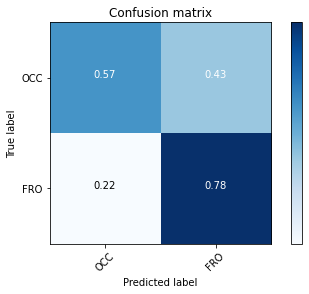

In [175]:
cm = np.array([[13,10],[5,18]])
classes = ["OCC", "FRO"]
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)


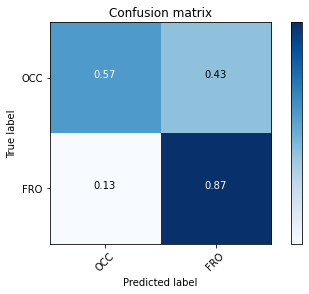

In [27]:
cm = np.array([[13,10],[ 3,20]])
classes = ["OCC", "FRO"]
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)



In [19]:
best_results = df_validation_svm.iloc[3]
#y = best_results.y
#predict_proba = best_results.y_proba

In [20]:
best_results

C                                                                 1.0
mean_score_test                                              0.717391
mean_score_train                                                  0.5
predict             [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, ...
std_score_test                                               0.331185
std_score_train                                                   0.0
y                   [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...
y_proba             [0.5690343360036415, 0.5690343360036415, 0.511...
Name: 3, dtype: object

In [24]:
predict_proba = best_results.y_proba
y = best_results.y

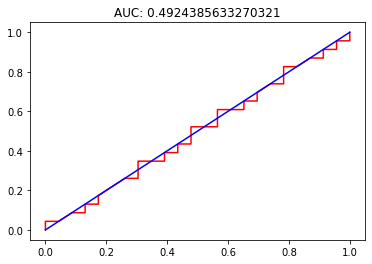

In [25]:
plot_roc_auc(y, predict_proba)